# General Assembly Data Science Immersive - Capstone Project #

## Creating an automated English language error detector ##

## Part 3: EDA feature selection, modelling and classifier evaluation - overview of process

This is the third and final part of my data science immersive Capstone Project, covering the exploratory data analysis and modelling phase.

In Part 2, I created clean dataframes for training and test sets containing a wide range of features based on Google Books Ngram counts and part of speech tags. I will now use these to perform data analysis, select features and then tune / evaluate classification models.

I begin with some detailed exploratory data analysis to help me a) select features to be used in the model and b) select appropriate algorithms to use. I then move onto the modelling phase - developing three models (XGBoost, a MLP neural network and Random Forest), tuning hyperparameters using Bayesian optimisation before evaluating the best performing model on the holdout test set. Finally, I do some detailed evaluation of the model, analysing where it is performing particularly well / badly.

### A note on evaluation

Generally when it comes to language error detection or correction, there are three key issues that should be taken into account when carrying out evaluation of models:

1. **imbalanced classes: data is heavily weighted towards correct over incorrect**

For a heavily imbalanced dataset, accuracy is not a helpful evaluation metric. Instead, I will evaluate by looking at a combination of more detailed metrics (confusion matrix, F1 scores and, particularly, AUROC).

2. **precision v recall: precision of the error class is generally more important than recall; but not always.**

In a language checker, it's generally better to miss a few errors rather than miclassify perfectly good language as errors. However, this isn't always simply the case. 

Depending on the task, an end user might prefer to have a more sensitive model. A competent English speaker, for example, might tolerate more falsely-flagged errors knowing that they can double-check with their own knowledge or another system. What's more, some words / phrases are clearly wrong (e.g. obvious misspellings), but others might be debateable. For example, something may be *grammatically* correct and syntactically well-formed, but unnatural to a native speaker. 

As such, it will be important to look not only at the binary classification, but also at class probabilities / performance at different probability thresholds. Again, this suggests that visualising the ROC curve will be particularly important in terms of 

In [95]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, GridSearchCV, \
train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, \
roc_curve, roc_auc_score, auc, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA, LatentDirichletAllocation
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer
import ErrorDetection as ed
import importlib
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
importlib.reload(ed)

<module 'ErrorDetection' from '/Users/adamglass/DSI/DSI6-lessons/projects/project-capstone/ErrorDetection.py'>

## 1. Load CSV files saved in Part 2 

In [3]:
df_train = pd.read_csv('fce_train_final.csv', index_col=0)
df_test = pd.read_csv('fce_test_final.csv', index_col=0)
pos_train = pd.read_csv('fce_pos_train_final.csv', index_col=0)
pos_test = pd.read_csv('fce_pos_test_final.csv', index_col=0)

In [4]:
mask = df_train["word"] == "&"
df_train = df_train[~mask]
mask = pos_train["0"] == "&"
pos_train = pos_train[~mask]

In [5]:
mask = df_test["word"] == "&"
df_test = df_test[~mask]
mask = pos_test["0"] == "&"
pos_test = pos_test[~mask]

In [41]:
# Quickly check the data
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 452427 entries, 0 to 452832
Data columns (total 53 columns):
word                      452427 non-null object
y                         452427 non-null int64
unigram_1                 452427 non-null float64
bigram_1                  452163 non-null float64
bigram_2                  395337 non-null float64
trigram_1                 450031 non-null float64
trigram_2                 393918 non-null float64
trigram_3                 341981 non-null float64
fourgram_1                445774 non-null float64
fourgram_2                392303 non-null float64
fourgram_3                341195 non-null float64
fourgram_4                292454 non-null float64
fivegram_1                442545 non-null float64
fivegram_2                389944 non-null float64
fivegram_3                339600 non-null float64
fivegram_4                291501 non-null float64
fivegram_5                246283 non-null float64
proba_bigram_1            450650 non-null 

In [6]:
# drop the context columns that won't be used as features
to_drop = list(df_train.loc[:, "bigram_left_context":"fivegram_right_context"].columns)
df_train.drop(columns=to_drop, inplace=True)
df_test.drop(columns=to_drop, inplace=True)

## 2. EDA

I will now move onto exploratory data analysis. The purpose of this step is to support feature and initial model selection, as well as to identify any further processing / engineering that might be required.

### Class balance and baseline

I will begin by looking at the balance between incorrect and correct words. The majority class will serve as our baseline (zero rule).

baseline: 0.8699237667071151


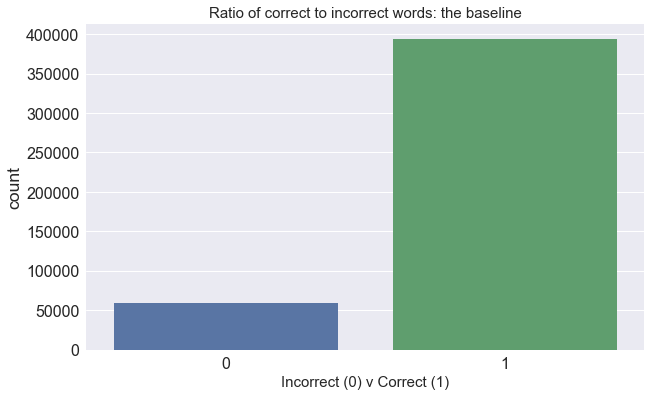

In [110]:
# create bar chart
fig, ax = plt.subplots(figsize=[10,6])
sns.countplot(df_train["y"])
plt.xlabel("Incorrect (0) v Correct (1)", fontsize=15);
plt.title("Ratio of correct to incorrect words: the baseline", fontsize=15);
print("baseline:", df_train["y"].mean())

There is a clear imbalance in the classes, with 86.99% of our words being correct.

This may present some problems later on in evaluating the result of our classifier. Rather than using accuracy, we should focus more on precision and recall scores (as well as AUC ROC to measure our model against one that simply predicted the majority class).

### Correlations

To get a high-level overview of the potential associations between our features and outcome variables, let's start by looking at a correlation matrix and heatmap.

Let's start by looking at correlations with the outcome variable specifically

In [280]:
columns = list(df_train.loc[:, "unigram_1":"fivegram_sum_threshold"].columns) + ["proper_noun"]
df_train[columns].corrwith(df_train["y"])

unigram_1                 0.181406
bigram_1                  0.201072
bigram_2                  0.151228
trigram_1                 0.192623
trigram_2                 0.196180
trigram_3                 0.144935
fourgram_1                0.167680
fourgram_2                0.177730
fourgram_3                0.171834
fourgram_4                0.116689
fivegram_1                0.130265
fivegram_2                0.138821
fivegram_3                0.135051
fivegram_4                0.121170
fivegram_5                0.083046
proba_bigram_1            0.233772
proba_trigram_1           0.233408
proba_fourgram_1          0.203378
proba_fivegram_1          0.171384
proba_bigram_2            0.200609
proba_trigram_3           0.178195
proba_fourgram_4          0.151276
proba_fivegram_5          0.124797
proba_word                0.152715
unigram_mean              0.181406
bigram_mean               0.211419
trigram_mean              0.219974
fourgram_mean             0.201158
fivegram_mean       

Next let's look at predictor correlations and any multi-colinearity

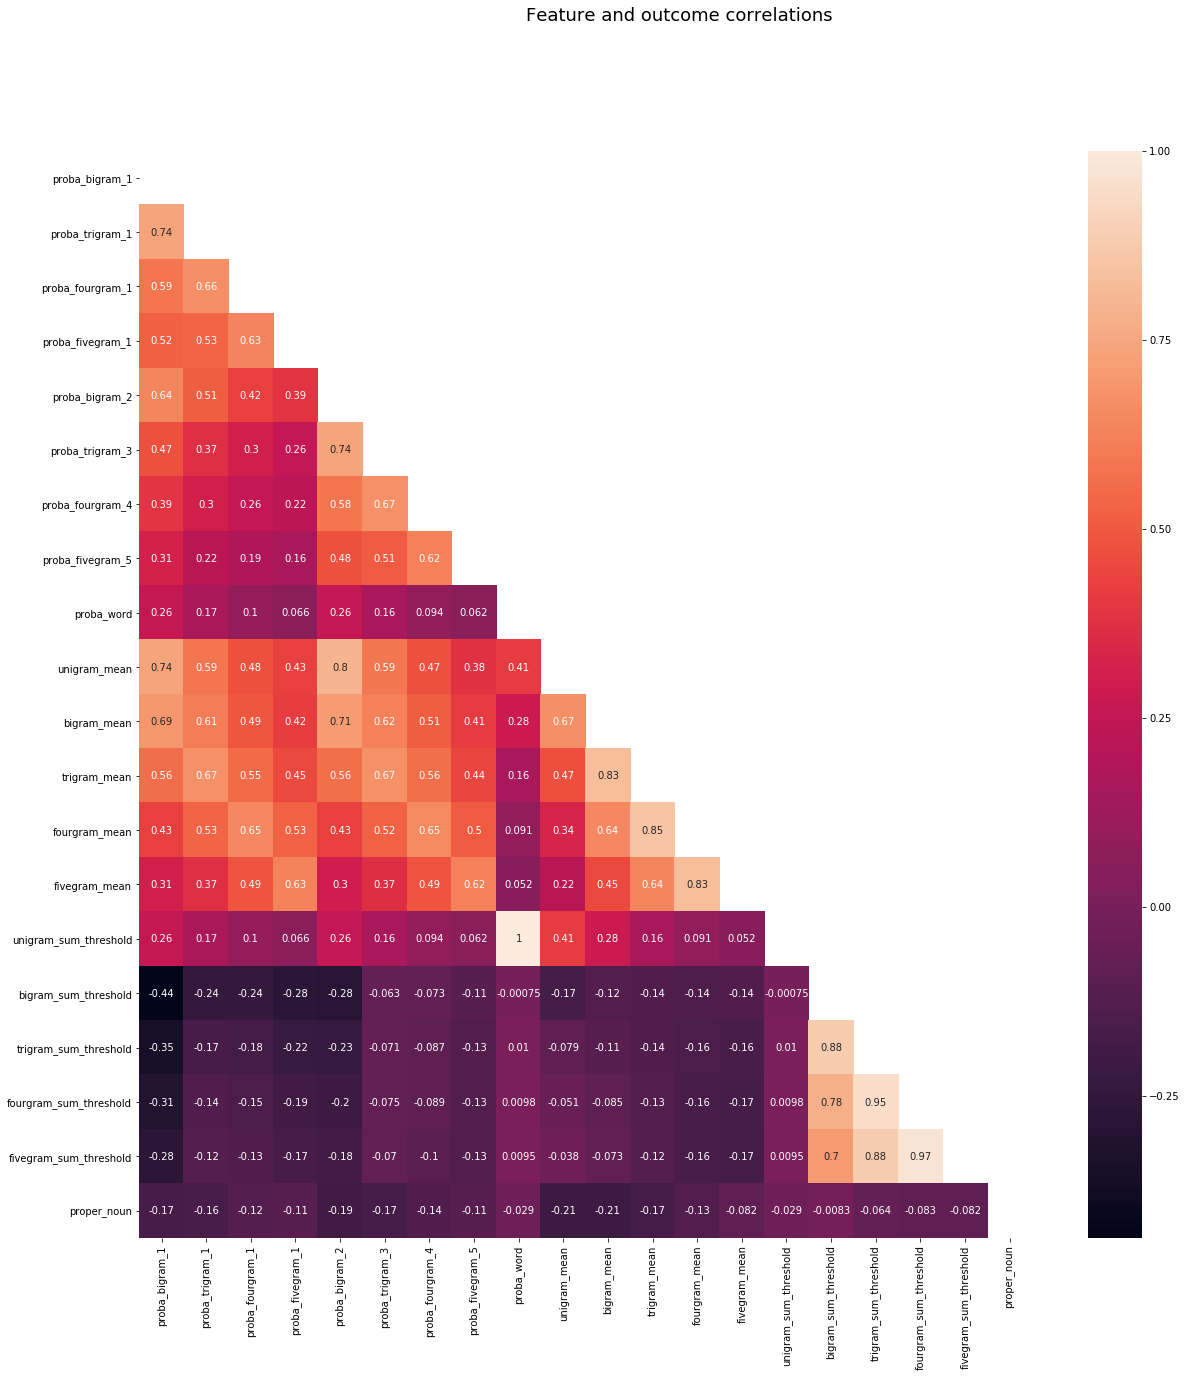

In [281]:
# Generate a mask for the upper triangle (taken from seaborn example gallery)
columns = list(df_train.loc[:, "proba_bigram_1":"fivegram_sum_threshold"].columns) + ["proper_noun"]
mask = np.zeros_like(df_train[columns].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True         # triu: TRIangle Upper

fig, ax = plt.subplots(figsize=(20,20))

# Plot the heatmap with seaborn.
sns.heatmap(df_train[columns].corr(), mask=mask,ax=ax,annot=True)
plt.suptitle("Feature and outcome correlations", fontsize=18)

plt.show()

### Analysis

#### Correlations with outcome variable

Looking first at the correlations with the outcome variable, it's not a positive picture! Unfortunately it appears as if correlations are all weak to moderate, the strongest (as a group) being the ngram probabilities.

An interesting finding here is that bigram- and trigram-based features seem to be most correlated with our outcome variable and features derived from fivegrams have a particularly low correlation. A reason for the latter might be data sparsity: even in a corpus as large as the Google Books repository, it is likely that some fivegrams get a zero match count simply because that permutation has simply never been written in a book before and not because they it contains an error.

The features derived by summing the number of ngrams with counts above an Q1 - IQR * 3 threshold performs the worst. This could be because of setting the threshold too high, so some further investigation / feature engineering might be required.

#### Correlations between predictors

Another important thing to note is that there is a large degree of multicolinearity. This was to be expected, given how the features have been engineered in a similar way, but it should be taken into account when selecting and tuning my classifiers as it could be detrimental to performance. 

Given the low number of features and weak correlations with the outcome variable, I should be very careful about removing features due to the risk of throwing out signal.

A better option would be to select classifiers that are more robust with regard to multicolinearity (e.g. decision tree based ensemble algorithms) or consider using Principal Component Analysis.


### How well do our predictor variable separate the classes?

Next, it would be useful to look in a bit more depth at the distributions of those features that have the strongest correlations to see how well they can separate our two classes.
### Ngram mean distributions

Let's start by visualising the distribution of ngram means, separated by class and with a normalised scale to account for the large class imbalance.

As explained in the Part 2 notebook, my hypothesis was that incorrect words should appear in more lower / zero count ngrams, which would result in these words having a significant difference in their mean counts. What we should hope to see in our plots is a clear separation in the distribution classes that would provide good signal to classifier.

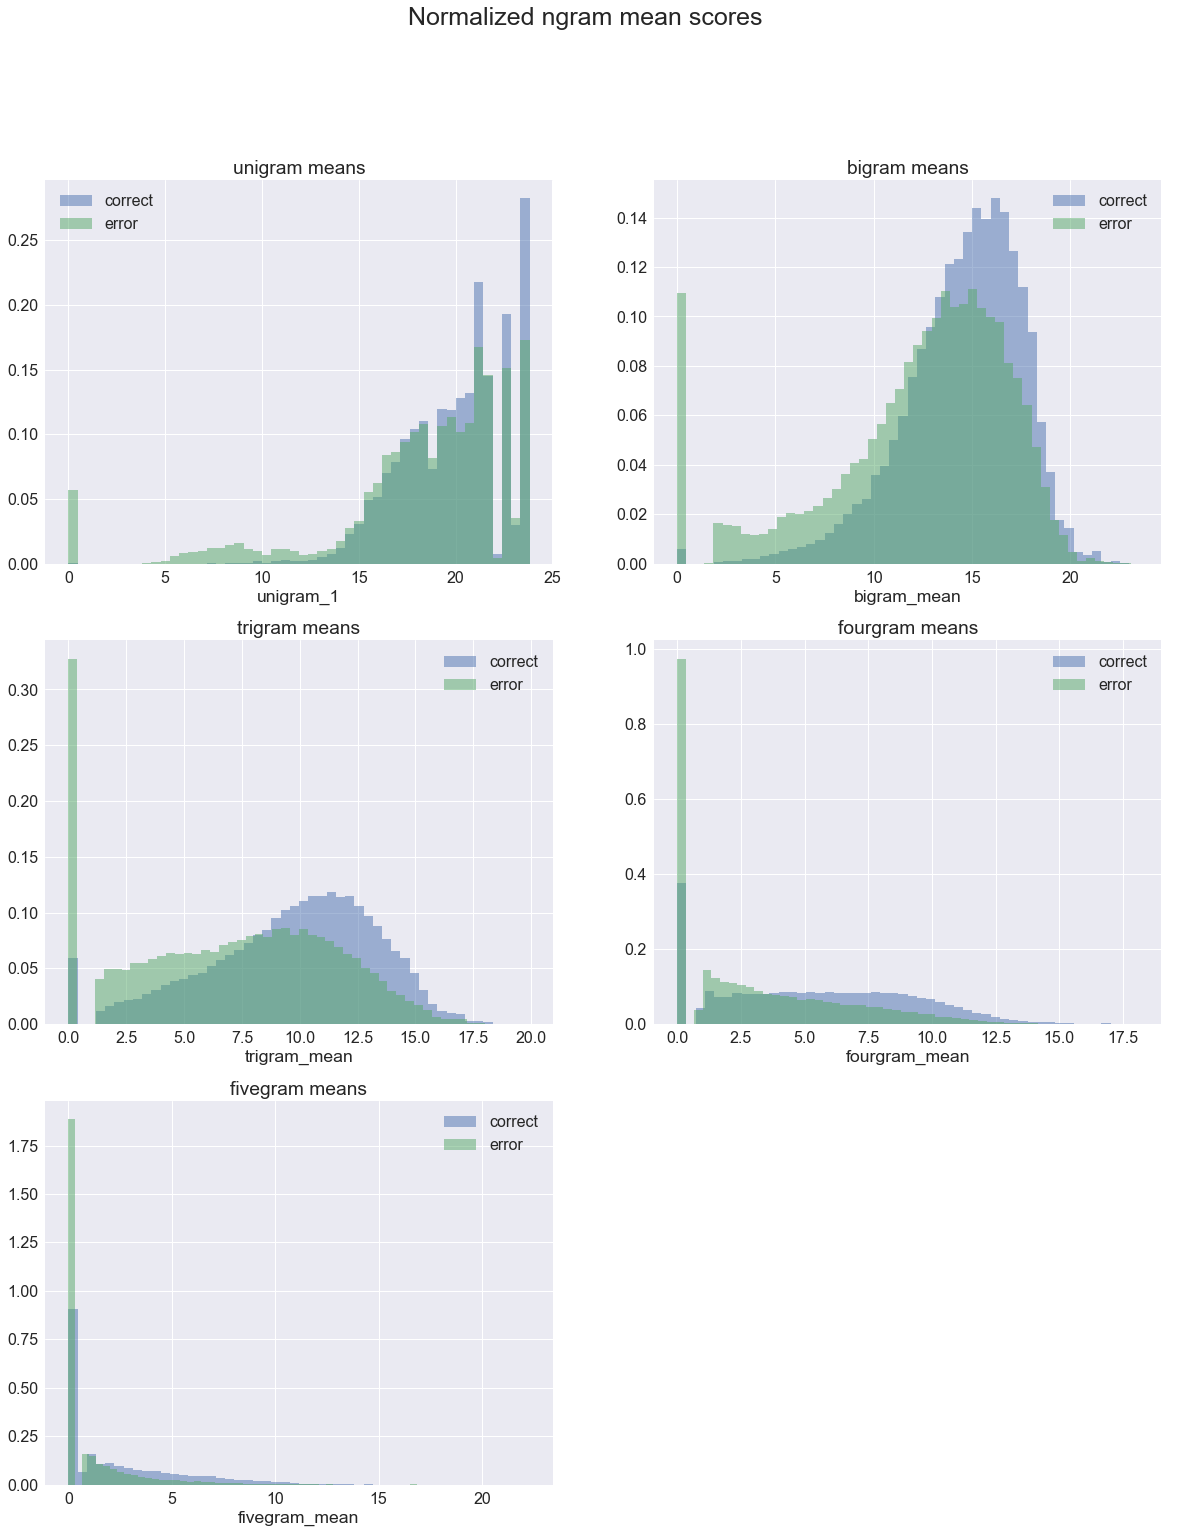

In [122]:
# first, crate masks to filter out null values as these can't be handled in plots 
# and to separate classes
mask = (df_train["y"] == 1) & (df_train["fivegram_mean"].isnull()==False)
mask_2 = (df_train["y"] == 0) & (df_train["fivegram_mean"].isnull()==False)

# Creeate subplots using seaborn and matplotlib
fig, ax = plt.subplots(figsize=(20,24), nrows=3, ncols=2)
sns.distplot(df_train.loc[mask,"unigram_1"], norm_hist=True, 
             kde=False, hist_kws={'alpha':0.5}, ax=ax[0][0])
sns.distplot(df_train.loc[mask_2,"unigram_1"], norm_hist=True,
             kde=False, hist_kws={'alpha':0.5}, ax=ax[0][0])
sns.distplot(df_train.loc[mask,"bigram_mean"], norm_hist=True, 
             kde=False, hist_kws={'alpha':0.5}, ax=ax[0][1])
sns.distplot(df_train.loc[mask_2,"bigram_mean"], norm_hist=True,
             kde=False, hist_kws={'alpha':0.5}, ax=ax[0][1])
sns.distplot(df_train.loc[mask,"trigram_mean"], norm_hist=True,
             kde=False, hist_kws={'alpha':0.5}, ax=ax[1][0])
sns.distplot(df_train.loc[mask_2,"trigram_mean"], norm_hist=True, 
             kde=False, hist_kws={'alpha':0.5}, ax=ax[1][0])
sns.distplot(df_train.loc[mask,"fourgram_mean"], norm_hist=True,
             kde=False, hist_kws={'alpha':0.5}, ax=ax[1][1])
sns.distplot(df_train.loc[mask_2,"fourgram_mean"], norm_hist=True, 
             kde=False, hist_kws={'alpha':0.5}, ax=ax[1][1])
sns.distplot(df_train.loc[mask,"fivegram_mean"], norm_hist=True, 
             kde=False, hist_kws={'alpha':0.5}, ax=ax[2][0])
sns.distplot(df_train.loc[mask_2,"fivegram_mean"], norm_hist=True, 
             kde=False, hist_kws={'alpha':0.5}, ax=ax[2][0])

# remove empty axis
ax[2][1].axis("off")

# create legend
ax[0][0].legend(["correct", "error"])
ax[0][1].legend(["correct", "error"])
ax[1][0].legend(["correct", "error"])
ax[1][1].legend(["correct", "error"])
ax[2][0].legend(["correct", "error"])

# title and label
ax[0][0].set_title("unigram means")
ax[0][1].set_title("bigram means")

ax[1][0].set_title("trigram means")

ax[1][1].set_title("fourgram means")

ax[2][0].set_title("fivegram means")


fig.suptitle("Normalized ngram mean scores", fontsize=25)
plt.show()


### Analysis

Ignoring the zero values, our lower order ngrams are skewed to the left with higher counts being much more common. This pattern changes as ngram length increases, with the distribution flattening out and then becoming skewed to the right.

This is intuitive - in a huge corpus of written text, single or pairs of words are more likely to appear in high frequencies or not at all. Whereas the larger number of permutations for longer sequences of words means that we'd expect high frequency ngrams to be less likely.

However, we are less interested in describing the centre, spread and shape of our ngrams and more in whether there is a clear difference and separation in the classes.

#### Differences between classes: significant at the margins, but too much overlap in the middle

The plots show a clear *difference* in classes between all ngram means, but not a clear *separation* in classes. The difference appears to be most marked for bigram and trigram means (which probably reflects the correlations we found above).

Another interesting finding is that the difference in classes appears to be greater for those ngrams with zero counts. Particularly for lower order ngrams, a much higher proportion of the zero means are accounted for by incorrect words. This is most obvious for unigram and bigram means where almost no correct words have zero counts. On the other hand, it also appears that there are very few *incorrect* words with high fivegram means.

This suggests that very high and very low counts are most associated with correct / incorrect words, but that there is too much overlap in the middle to clearly separate out the classes. At many mean values across the middle of the distribution, it is common to have both correct and incorrect words. 

One reason for this could be the huge variability in the frequency of n-grams in the corpus skewing the means. For example, an incorrect word may have multiple n-grams with zero count, but it may also appear in one extremely common n-gram, which skews the result upwards. This may end up having a very similar mean value to a correct word that has just one or no zero count n-grams.

Correct words that appear directly before or after an incorrect word would be particularly susceptible to this skewing.


### Looking only at words with zero value means

Let's hone in specifically on words where ngram means are zero to see if the finding highlighted above holds up under further scrutiny.

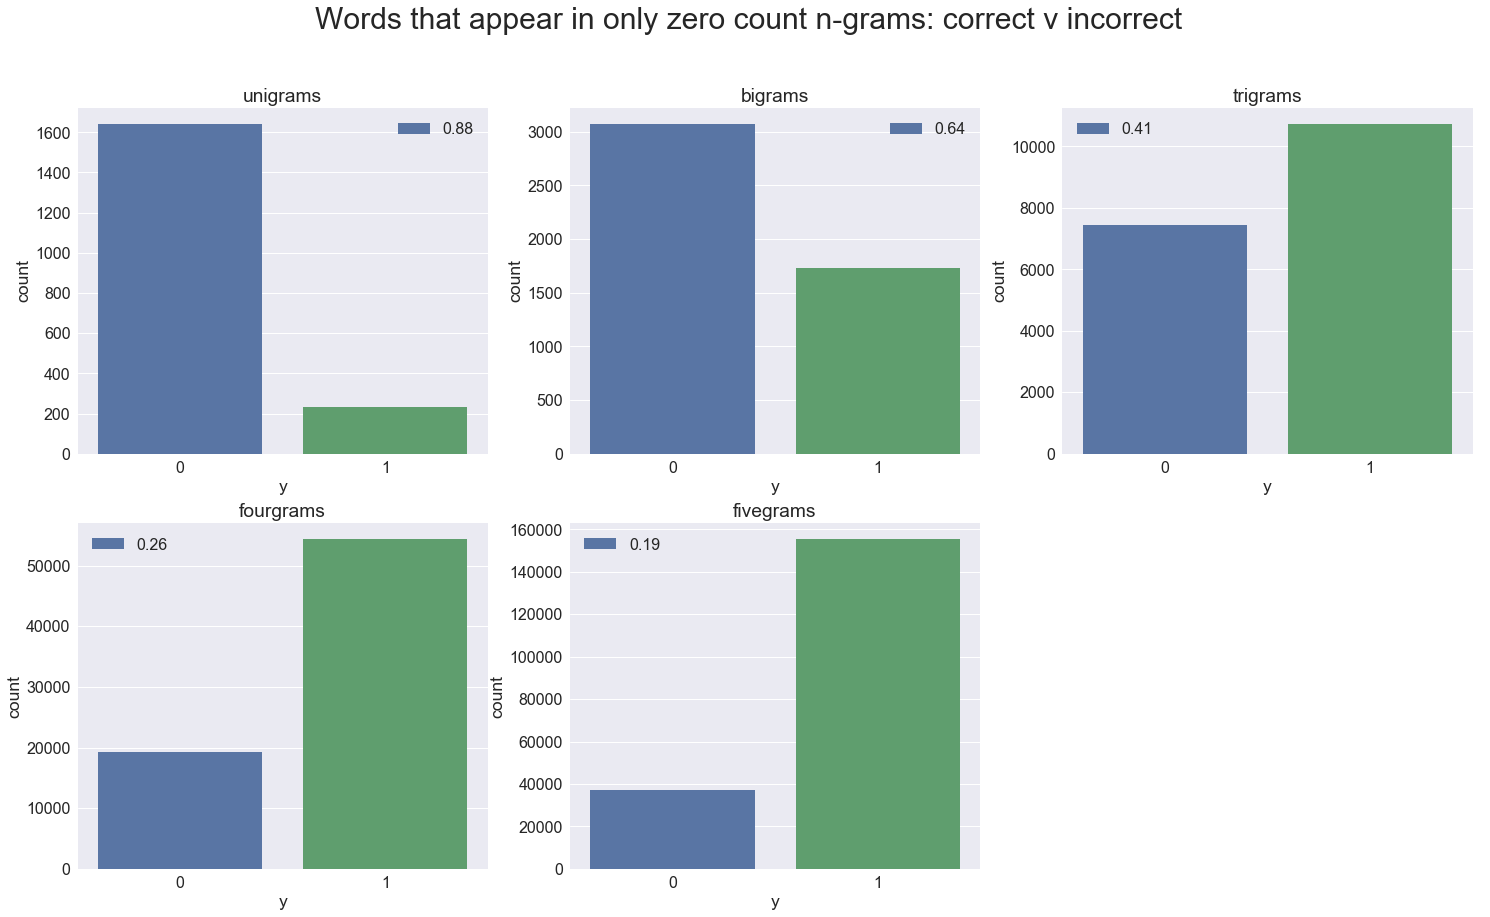

In [121]:
# create bar plot
fig, ax = plt.subplots(figsize=(25,14), nrows=2, ncols=3)

mask = (df_train["unigram_1"] == 0)
sns.countplot(df_train.loc[mask,"y"], ax=ax[0][0])
ax[0][0].set_title("unigrams")
ax[0][0].legend([round(1-df_train.loc[mask, "y"].mean(), 2)])

mask = (df_train["bigram_mean"] == 0)
sns.countplot(df_train.loc[mask,"y"], ax=ax[0][1])
ax[0][1].set_title("bigrams")
ax[0][1].legend([round(1-df_train.loc[mask, "y"].mean(), 2)])

mask = (df_train["trigram_mean"] == 0)
sns.countplot(df_train.loc[mask,"y"], ax=ax[0][2])
ax[0][2].set_title("trigrams")
ax[0][2].legend([round(1-df_train.loc[mask, "y"].mean(), 2)])

mask = (df_train["fourgram_mean"] == 0)
sns.countplot(df_train.loc[mask,"y"], ax=ax[1][0])
ax[1][0].set_title("fourgrams")
ax[1][0].legend([round(1-df_train.loc[mask, "y"].mean(), 2)])

mask = (df_train["fivegram_mean"] == 0)
sns.countplot(df_train.loc[mask,"y"], ax=ax[1][1])
ax[1][1].set_title("fivegrams")
ax[1][1].legend([round(1-df_train.loc[mask, "y"].mean(), 2)])
ax[1][2].axis("off")

fig.suptitle("Words that appear in only zero count n-grams: correct v incorrect \n", fontsize=30)
plt.show()


### Analysis

This futher confirms the picture above - having a zero count in a unigram or bigram seems to be very strongly associated with being an error. 88% and 64% of words with zero count ngram means compared to a baseline of 13%.


## Controlling for proper noun-induced sparsity

Recall that in Part 2, I decided to extract a binary feature of whether a word is a proper noun or not. My reasoning for this was a concern that proper nouns could be biasing the data - causing zero counts in ngrams that are correct due to sparsity.

As such, it would be useful to rerun the bar chart code above, but with proper nouns removed. It would be interesting to see whether proper nouns are, in fact, skewing the zero counts.






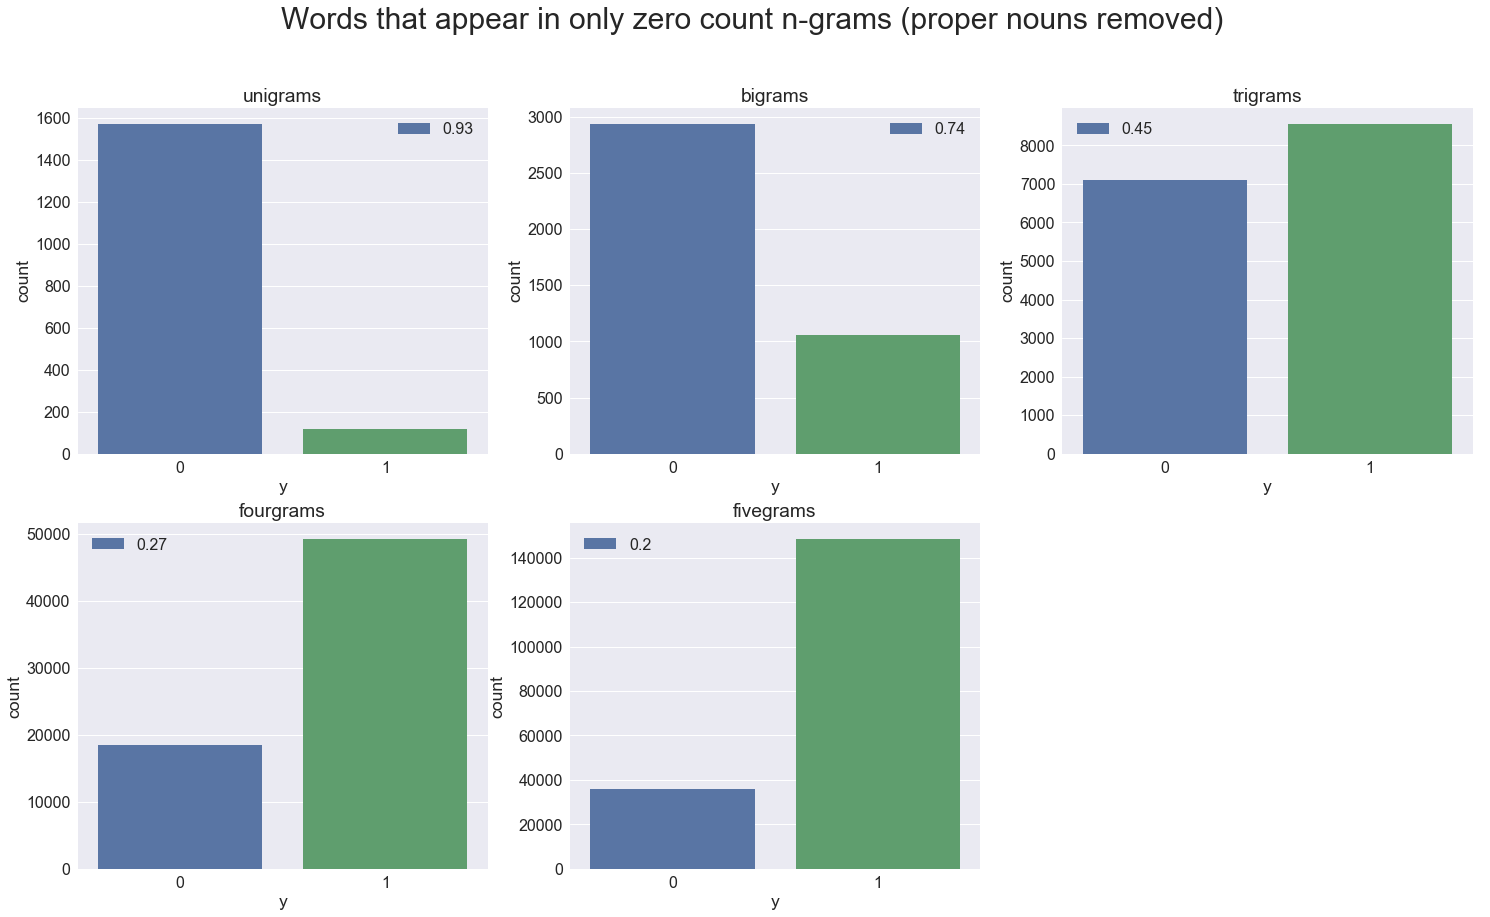

In [120]:
# create bar plot
fig, ax = plt.subplots(figsize=(25,14), nrows=2, ncols=3)

mask = (df_train["unigram_1"] == 0) & (df_train["proper_noun"] == 0) 
sns.countplot(df_train.loc[mask,"y"], ax=ax[0][0])
ax[0][0].set_title("unigrams")
ax[0][0].legend([round(1-df_train.loc[mask, "y"].mean(), 2)])

mask = (df_train["bigram_mean"] == 0) & (df_train["proper_noun"] == 0) 
sns.countplot(df_train.loc[mask,"y"], ax=ax[0][1])
ax[0][1].set_title("bigrams")
ax[0][1].legend([round(1-df_train.loc[mask, "y"].mean(), 2)])

mask = (df_train["trigram_mean"] == 0) & (df_train["proper_noun"] == 0) 
sns.countplot(df_train.loc[mask,"y"], ax=ax[0][2])
ax[0][2].set_title("trigrams")
ax[0][2].legend([round(1-df_train.loc[mask, "y"].mean(), 2)])

mask = (df_train["fourgram_mean"] == 0) & (df_train["proper_noun"] == 0) 
sns.countplot(df_train.loc[mask,"y"], ax=ax[1][0])
ax[1][0].set_title("fourgrams")
ax[1][0].legend([round(1-df_train.loc[mask, "y"].mean(), 2)])

mask = (df_train["fivegram_mean"] == 0) & (df_train["proper_noun"] == 0) 
sns.countplot(df_train.loc[mask,"y"], ax=ax[1][1])
ax[1][1].set_title("fivegrams")
ax[1][1].legend([round(1-df_train.loc[mask, "y"].mean(), 2)])
ax[1][2].axis("off")

fig.suptitle("Words that appear in only zero count n-grams (proper nouns removed)", fontsize=30)
plt.show()


### Analysis

Interestingly, my intuition was correct. Once we remove the proper nouns, the proportion of ngrams that have a zero count but are also correct decreases. This happens almost across the board, but is particularly significant for unigrams and bigrams.


## Ngram probability distributions

As with our ngram means, I will also look at the distributions of our probabilities to try and identify class separation.

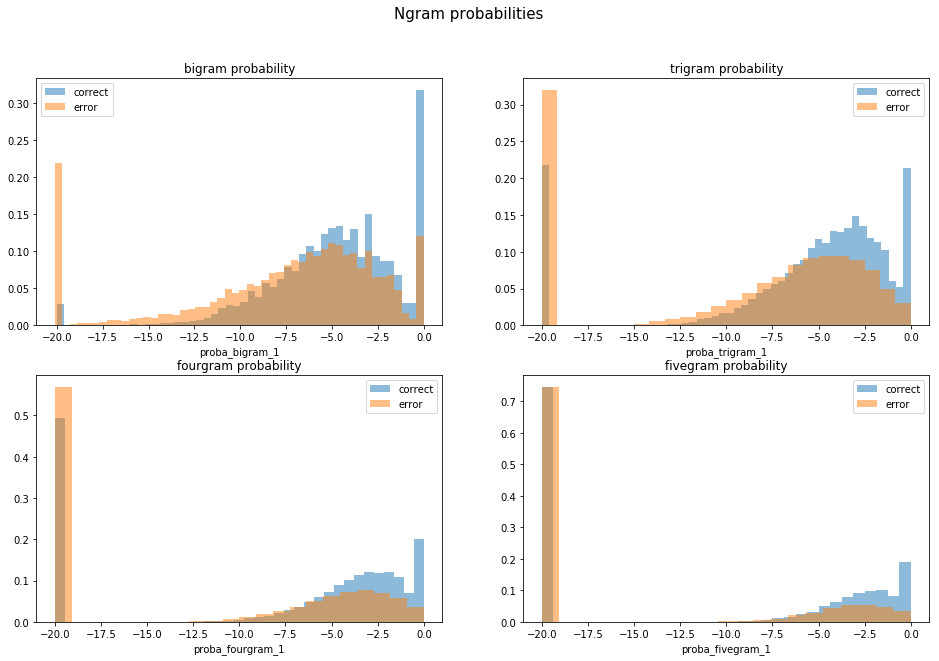

In [65]:
# first, crate masks to filter out null values as these can't be handled in plots 
# and to separate classes

# Creeate subplots using seaborn and matplotlib
fig, ax = plt.subplots(figsize=(16,10), nrows=2, ncols=2)

mask = (df_train["y"] == 1) & (df_train["proba_bigram_1"].isnull()==False)
mask_2 = (df_train["y"] == 0) & (df_train["proba_bigram_1"].isnull()==False)
sns.distplot(df_train.loc[mask,"proba_bigram_1"], norm_hist=True, 
             kde=False, hist_kws={'alpha':0.5}, ax=ax[0][0])
sns.distplot(df_train.loc[mask_2,"proba_bigram_1"], norm_hist=True,
             kde=False, hist_kws={'alpha':0.5}, ax=ax[0][0])

mask = (df_train["y"] == 1) & (df_train["proba_trigram_1"].isnull()==False)
mask_2 = (df_train["y"] == 0) & (df_train["proba_trigram_1"].isnull()==False)
sns.distplot(df_train.loc[mask,"proba_trigram_1"], norm_hist=True, 
             kde=False, hist_kws={'alpha':0.5}, ax=ax[0][1])
sns.distplot(df_train.loc[mask_2,"proba_trigram_1"], norm_hist=True,
             kde=False, hist_kws={'alpha':0.5}, ax=ax[0][1])

mask = (df_train["y"] == 1) & (df_train["proba_fourgram_1"].isnull()==False)
mask_2 = (df_train["y"] == 0) & (df_train["proba_fourgram_1"].isnull()==False)
sns.distplot(df_train.loc[mask,"proba_fourgram_1"], norm_hist=True,
             kde=False, hist_kws={'alpha':0.5}, ax=ax[1][0])
sns.distplot(df_train.loc[mask_2,"proba_fourgram_1"], norm_hist=True, 
             kde=False, hist_kws={'alpha':0.5}, ax=ax[1][0])

mask = (df_train["y"] == 1) & (df_train["proba_fivegram_1"].isnull()==False)
mask_2 = (df_train["y"] == 0) & (df_train["proba_fivegram_1"].isnull()==False)
sns.distplot(df_train.loc[mask,"proba_fivegram_1"], norm_hist=True,
             kde=False, hist_kws={'alpha':0.5}, ax=ax[1][1])
sns.distplot(df_train.loc[mask_2,"proba_fivegram_1"], norm_hist=True, 
             kde=False, hist_kws={'alpha':0.5}, ax=ax[1][1])


# create legend
ax[0][0].legend(["correct", "error"])
ax[0][1].legend(["correct", "error"])
ax[1][0].legend(["correct", "error"])
ax[1][1].legend(["correct", "error"])

# title and label
ax[0][0].set_title("bigram probability")

ax[0][1].set_title("trigram probability")

ax[1][0].set_title("fourgram probability")

ax[1][1].set_title("fivegram probability")


fig.suptitle("Ngram probabilities", fontsize=15)
plt.show()


### Analysis

These distributions look very similar to what we saw with the ngram means. However, there appears to be one important difference. While for our ngram means, having a zero count seemed to be most strongly associated with being an error, in this case it is the *highest* value that is most strongly associated with being correct.

Unfortunately, there does appear to be the same issue with strong overlap across the middle values. This may be problematic for a machine learning classifier in finding an appropriate decision threshold.

## Boxplots of means and probabilities

One final way to explore the data is to look at side-by-side boxplots of each ngram mean and probability by class. Again, this will help us to identify separation points between the classes.

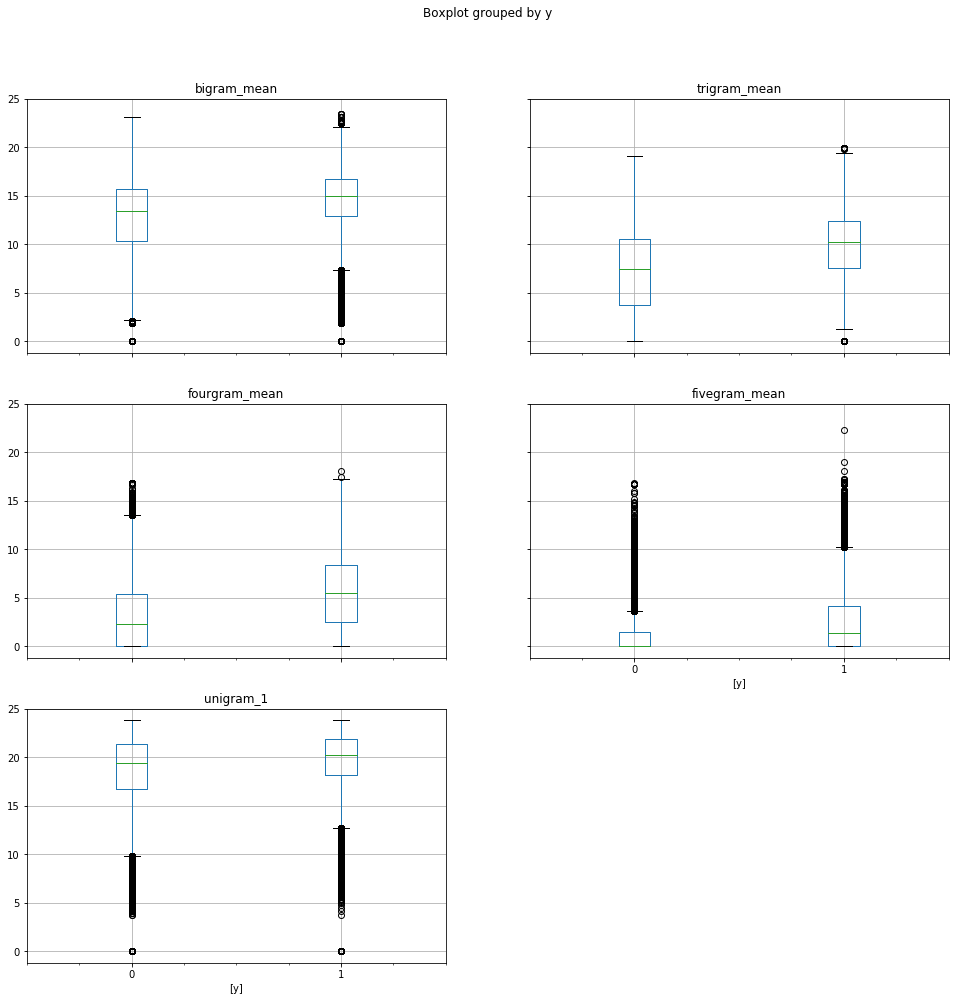

In [94]:
columns = list(df_train.loc[:, "bigram_mean":"fivegram_mean"].columns) + ["unigram_1"]
mask = df_train.loc[:,columns].notnull().all(axis=1) & (df_train["proper_noun"] == 0)
bp = df_train.loc[mask].boxplot(column=columns, by=['y'], figsize=(16,16))

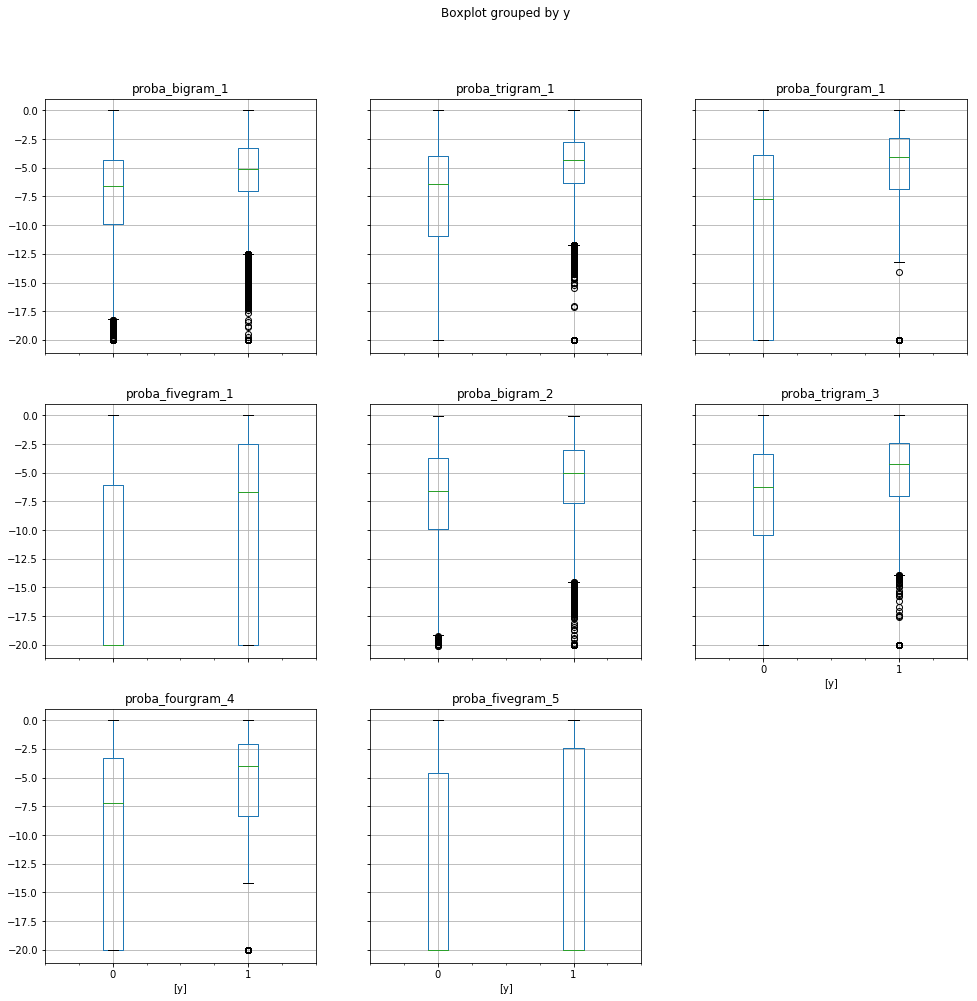

In [95]:
columns = list(df_train.loc[:, "proba_bigram_1":"proba_fivegram_5"].columns)
mask = df_train.loc[:,columns].notnull().all(axis=1) & (df_train["proper_noun"] == 0)
bp = df_train.loc[mask].boxplot(column=columns, by=['y'], figsize=(16,16))

### Analysis

As before, the difference between the classes is apparent, but no clear decision threshold is appearing. However, for the fourgram probabilities, it does appear that below a log probability of around -13 to -14, it is very unlikely that a word is correct. 

## EDA Conclusions

- **Correlations are weak to moderate:** Most of the engineered features were only weakly to moderately correlated with our outcome variable. This does not bode too well for a classifier model.
- **Strongest features appear to be ngram probabilities and means:** as expected, ngram probabilities and ngram mean counts had the strongest correlations. The feature created by summing all ngrams of each length above a certain threshold had practically no correlation.
- **There are clear differences between classes, but not clear separation:** analysing the distribution of ngram means and probabilities did show significant differences for all ngrams, but it was hard to see a clear separation in classes. 
- **Counts and probabilities are better at separating classes at the margins:** an interesting finding was that zero mean counts and high probabilities were the best at separating the classes.
- **Proper nouns do appear to be skewing the results:** as intuited in Part 2, it does appear that proper nouns are biasing the results by creating false zero counts. I will have to take this into account when modelling.

## 3. Feature selection and modelling

Based on the findings from the EDA, I will begin by creating models using ngram probabilities and mean counts, dropping the other features (as these had very low correlations). I will also include the binary is/not a proper noun as a feature.

In terms of tuning models, I will compare three powerful models:

- XGBoost: best in class gradient boosting algorithm
- Neural network: multilayer perceptron classifier
- Random Forest: decision tree-based ensemble classifier

I have decided to lean towards decision tree based algorithms given that they are more robust to the multi co-linearity in my features. However, I will also compare these with a MLP classifier as a very powerful alternative to decision tress.

### Modelling process

1. **Create a further train / test split: ** I will start by dividing the training set into a further 70/30 train/test split. This will enable me to tune and compare my models using this newly created test set and keep the pre-made test set as a holdout set for final evaluation of generalisation errors. Given the large size of the of the training set (over 400,000 observations), I have preferred this simple split of the data over K-Fold cross-validation, which would be unlikely to offer much additional benefit given the time and resource cost.

2. **Tune the models and find optimal hyperparameters using Bayesian optimisation: ** I will then tune each of the models using the Hyoperopt library, compare the results and choose the best model. 
3. **Evaluate the models using the held-out test set: ** The final step is to pick the best model, train on the whole training set and evaluate on the holdout set.



### Create training and test matrices

First, I will create the additional test matrix to be used for tuning.

In [7]:
# Create the predictor matrix
columns = list(df_train.loc[:, "unigram_mean":"fivegram_mean"].columns) + ["proba_word"] + list(
    df_train.loc[:, "proba_bigram_1":"proba_fivegram_5"].columns) + ["proper_noun"]
X = df_train.loc[:, columns]
y = df_train["y"]

### Stratify or shuffle?

Ideally, we should avoid shuffling our data when splitting, as new language data for checking purposes will almost always be in sequential sentences and documents. 

However, the cost of this is potentially having an imbalance in class proportions between our splits. Let's try a non-shuffled split and if the class proportions are close enough, I will proceed. Otherwise I will proceed with shuffling the data.

In [8]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, shuffle=False)

In [9]:
print("ytrain mean: ", ytrain.mean())
print("ytest mean: ", ytest.mean())

ytrain mean:  0.8708201504272209
ytest mean:  0.8678322245061851


Fortunately, these are sufficiently close so as not to require any manual shuffling and stratifying.

### Creating the holdout evaluation matrix

In [10]:
columns = list(df_test.loc[:, "unigram_mean":"fivegram_mean"].columns) + ["proba_word"] + list(
    df_test.loc[:, "proba_bigram_1":"proba_fivegram_5"].columns) + ["proper_noun"]
Xeval = df_test.loc[:, columns]
yeval = df_test.y

In [11]:
print("yeval mean: ", yeval.mean())

yeval mean:  0.8479986488768789


In [12]:
# forward fill to remove null values
Xtrain.loc[:, "unigram_mean":"fivegram_mean"] = Xtrain.loc[
    :, "unigram_mean":"fivegram_mean"].fillna(method='ffill', axis=1)
Xtrain.loc[:, "proba_word":"proba_fivegram_5"] = Xtrain.loc[
    :, "proba_word":"proba_fivegram_5"].fillna(method='ffill', axis=1)

In [13]:
Xtest.loc[:, "unigram_mean":"fivegram_mean"] = Xtest.loc[
    :, "unigram_mean":"fivegram_mean"].fillna(method='ffill', axis=1)
Xtest.loc[:, "proba_word":"proba_fivegram_5"] = Xtest.loc[
    :, "proba_word":"proba_fivegram_5"].fillna(method='ffill', axis=1)

In [14]:
Xeval.loc[:, "unigram_mean":"fivegram_mean"] = Xeval.loc[
    :, "unigram_mean":"fivegram_mean"].fillna(method='ffill', axis=1)
Xeval.loc[:, "proba_word":"proba_fivegram_5"] = Xeval.loc[
    :, "proba_word":"proba_fivegram_5"].fillna(method='ffill', axis=1)

### Tuning XGBoost hyperparameters using Bayesian Optimization

I will start by tuning an XGBoost model - training on the train set and tuning by evaluating on the test set. Due to having imbalanced classes, I will use auroc scoring to tune the model.

For efficient hyperparamater tuning, I will use the Hyperopt library, which enables Bayesian Optimization.

In [15]:
# instantiate the XGBoost model
xgb = XGBClassifier(learning_rate=0.1)

In [16]:
# import Hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval

In [29]:
# find the optimal hyperparameters using Bayesian optimization - tuned using auc score
def objective(space):

    xgb = XGBClassifier(n_estimators = 100,
                            max_depth = int(space['max_depth']),
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                       )

    eval_set  = [( Xtrain, ytrain), ( Xtest, ytest)]

    xgb.fit(Xtrain, ytrain,
            eval_set=eval_set, eval_metric="auc",
            early_stopping_rounds=30)

    pred = xgb.predict_proba(Xtest)[:,1]
    pred_ = xgb.predict(Xtest)
    auc = roc_auc_score(ytest, pred)
    acc = accuracy_score(ytest, pred_)
    f1 = f1_score(ytest, pred_)
    print("AUC: ", auc)
    print("Accuracy: ", acc)
    print("f1_score: ", f1)
    return {'loss':1-auc, 'status': STATUS_OK }


space ={
        'max_depth': hp.quniform("x_max_depth", 5, 30, 1),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
    }

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,
            trials=trials)

[0]	validation_0-auc:0.80517	validation_1-auc:0.740963
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.833664	validation_1-auc:0.756523
[2]	validation_0-auc:0.849728	validation_1-auc:0.760624
[3]	validation_0-auc:0.862089	validation_1-auc:0.764567
[4]	validation_0-auc:0.871143	validation_1-auc:0.767066
[5]	validation_0-auc:0.879583	validation_1-auc:0.768839
[6]	validation_0-auc:0.886096	validation_1-auc:0.77053
[7]	validation_0-auc:0.891879	validation_1-auc:0.771619
[8]	validation_0-auc:0.897165	validation_1-auc:0.773423
[9]	validation_0-auc:0.902053	validation_1-auc:0.77501
[10]	validation_0-auc:0.906409	validation_1-auc:0.776184
[11]	validation_0-auc:0.910575	validation_1-auc:0.777013
[12]	validation_0-auc:0.914053	validation_1-auc:0.777642
[13]	validation_0-auc:0.917492	validation_1-auc:0.778307
[14]	validation_0-auc:0.920699	validation_1-auc:0.778812
[

[38]	validation_0-auc:0.996139	validation_1-auc:0.784722
[39]	validation_0-auc:0.996318	validation_1-auc:0.78499
[40]	validation_0-auc:0.996469	validation_1-auc:0.785308
[41]	validation_0-auc:0.996561	validation_1-auc:0.785358
[42]	validation_0-auc:0.996696	validation_1-auc:0.785702
[43]	validation_0-auc:0.9968	validation_1-auc:0.78586
[44]	validation_0-auc:0.996886	validation_1-auc:0.785969
[45]	validation_0-auc:0.996999	validation_1-auc:0.786136
[46]	validation_0-auc:0.997109	validation_1-auc:0.786439
[47]	validation_0-auc:0.997161	validation_1-auc:0.78681
[48]	validation_0-auc:0.997219	validation_1-auc:0.786846
[49]	validation_0-auc:0.997279	validation_1-auc:0.786997
[50]	validation_0-auc:0.997346	validation_1-auc:0.787138
[51]	validation_0-auc:0.997404	validation_1-auc:0.787309
[52]	validation_0-auc:0.997441	validation_1-auc:0.787598
[53]	validation_0-auc:0.997516	validation_1-auc:0.787691
[54]	validation_0-auc:0.997547	validation_1-auc:0.787801
[55]	validation_0-auc:0.997599	valid

[79]	validation_0-auc:0.810933	validation_1-auc:0.783528
[80]	validation_0-auc:0.811314	validation_1-auc:0.783664
[81]	validation_0-auc:0.811634	validation_1-auc:0.783712
[82]	validation_0-auc:0.812008	validation_1-auc:0.783864
[83]	validation_0-auc:0.812401	validation_1-auc:0.784038
[84]	validation_0-auc:0.812793	validation_1-auc:0.784133
[85]	validation_0-auc:0.81356	validation_1-auc:0.784653
[86]	validation_0-auc:0.813873	validation_1-auc:0.784838
[87]	validation_0-auc:0.813936	validation_1-auc:0.784896
[88]	validation_0-auc:0.814205	validation_1-auc:0.784994
[89]	validation_0-auc:0.814502	validation_1-auc:0.785063
[90]	validation_0-auc:0.814797	validation_1-auc:0.785042
[91]	validation_0-auc:0.814994	validation_1-auc:0.78508
[92]	validation_0-auc:0.815377	validation_1-auc:0.785358
[93]	validation_0-auc:0.815518	validation_1-auc:0.785407
[94]	validation_0-auc:0.816323	validation_1-auc:0.786038
[95]	validation_0-auc:0.816774	validation_1-auc:0.786332
[96]	validation_0-auc:0.816971	va

[16]	validation_0-auc:0.923548	validation_1-auc:0.780617
[17]	validation_0-auc:0.926247	validation_1-auc:0.780919
[18]	validation_0-auc:0.928596	validation_1-auc:0.781238
[19]	validation_0-auc:0.930994	validation_1-auc:0.781609
[20]	validation_0-auc:0.933419	validation_1-auc:0.782444
[21]	validation_0-auc:0.93534	validation_1-auc:0.782919
[22]	validation_0-auc:0.93737	validation_1-auc:0.783646
[23]	validation_0-auc:0.939147	validation_1-auc:0.7842
[24]	validation_0-auc:0.94087	validation_1-auc:0.784578
[25]	validation_0-auc:0.942542	validation_1-auc:0.78511
[26]	validation_0-auc:0.943955	validation_1-auc:0.785609
[27]	validation_0-auc:0.945405	validation_1-auc:0.785584
[28]	validation_0-auc:0.946909	validation_1-auc:0.785843
[29]	validation_0-auc:0.94825	validation_1-auc:0.786013
[30]	validation_0-auc:0.949631	validation_1-auc:0.786181
[31]	validation_0-auc:0.950818	validation_1-auc:0.786735
[32]	validation_0-auc:0.951955	validation_1-auc:0.787012
[33]	validation_0-auc:0.952899	validat

[57]	validation_0-auc:0.866574	validation_1-auc:0.788667
[58]	validation_0-auc:0.867731	validation_1-auc:0.788923
[59]	validation_0-auc:0.869058	validation_1-auc:0.789958
[60]	validation_0-auc:0.869715	validation_1-auc:0.789986
[61]	validation_0-auc:0.870167	validation_1-auc:0.790294
[62]	validation_0-auc:0.870997	validation_1-auc:0.790867
[63]	validation_0-auc:0.871507	validation_1-auc:0.79107
[64]	validation_0-auc:0.872268	validation_1-auc:0.791174
[65]	validation_0-auc:0.872595	validation_1-auc:0.791232
[66]	validation_0-auc:0.873111	validation_1-auc:0.791436
[67]	validation_0-auc:0.873592	validation_1-auc:0.791453
[68]	validation_0-auc:0.874057	validation_1-auc:0.7915
[69]	validation_0-auc:0.874387	validation_1-auc:0.791615
[70]	validation_0-auc:0.875166	validation_1-auc:0.791917
[71]	validation_0-auc:0.875729	validation_1-auc:0.792019
[72]	validation_0-auc:0.876486	validation_1-auc:0.792226
[73]	validation_0-auc:0.876716	validation_1-auc:0.792303
[74]	validation_0-auc:0.877059	val

[98]	validation_0-auc:0.919295	validation_1-auc:0.797004
[99]	validation_0-auc:0.919502	validation_1-auc:0.797019
AUC:  0.7970186555989582
Accuracy:  0.8838420676495075
f1_score:  0.9367568955281358
[0]	validation_0-auc:0.847664	validation_1-auc:0.733988
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.882849	validation_1-auc:0.74618
[2]	validation_0-auc:0.90547	validation_1-auc:0.752218
[3]	validation_0-auc:0.920389	validation_1-auc:0.755169
[4]	validation_0-auc:0.934568	validation_1-auc:0.759391
[5]	validation_0-auc:0.944626	validation_1-auc:0.762388
[6]	validation_0-auc:0.952435	validation_1-auc:0.763642
[7]	validation_0-auc:0.958439	validation_1-auc:0.764927
[8]	validation_0-auc:0.963734	validation_1-auc:0.765763
[9]	validation_0-auc:0.96884	validation_1-auc:0.767795
[10]	validation_0-auc:0.972691	validation_1-auc:0.768678
[11]	validation_0-auc:0.976288

[35]	validation_0-auc:0.784792	validation_1-auc:0.766476
[36]	validation_0-auc:0.785739	validation_1-auc:0.766956
[37]	validation_0-auc:0.786629	validation_1-auc:0.767558
[38]	validation_0-auc:0.787605	validation_1-auc:0.768391
[39]	validation_0-auc:0.788668	validation_1-auc:0.769211
[40]	validation_0-auc:0.789574	validation_1-auc:0.769905
[41]	validation_0-auc:0.790398	validation_1-auc:0.770654
[42]	validation_0-auc:0.791094	validation_1-auc:0.771179
[43]	validation_0-auc:0.791815	validation_1-auc:0.771787
[44]	validation_0-auc:0.792437	validation_1-auc:0.772275
[45]	validation_0-auc:0.792938	validation_1-auc:0.772584
[46]	validation_0-auc:0.793513	validation_1-auc:0.772825
[47]	validation_0-auc:0.794273	validation_1-auc:0.773142
[48]	validation_0-auc:0.79517	validation_1-auc:0.773636
[49]	validation_0-auc:0.795531	validation_1-auc:0.773789
[50]	validation_0-auc:0.796156	validation_1-auc:0.774206
[51]	validation_0-auc:0.796809	validation_1-auc:0.77462
[52]	validation_0-auc:0.797445	va

[76]	validation_0-auc:0.978253	validation_1-auc:0.792524
[77]	validation_0-auc:0.978456	validation_1-auc:0.792733
[78]	validation_0-auc:0.978658	validation_1-auc:0.792772
[79]	validation_0-auc:0.978827	validation_1-auc:0.792684
[80]	validation_0-auc:0.979158	validation_1-auc:0.79303
[81]	validation_0-auc:0.979416	validation_1-auc:0.793097
[82]	validation_0-auc:0.979632	validation_1-auc:0.793122
[83]	validation_0-auc:0.979925	validation_1-auc:0.793137
[84]	validation_0-auc:0.980072	validation_1-auc:0.793189
[85]	validation_0-auc:0.980289	validation_1-auc:0.793275
[86]	validation_0-auc:0.980507	validation_1-auc:0.793356
[87]	validation_0-auc:0.980726	validation_1-auc:0.793379
[88]	validation_0-auc:0.981064	validation_1-auc:0.793672
[89]	validation_0-auc:0.981342	validation_1-auc:0.793893
[90]	validation_0-auc:0.981579	validation_1-auc:0.7939
[91]	validation_0-auc:0.981787	validation_1-auc:0.793836
[92]	validation_0-auc:0.982113	validation_1-auc:0.793757
[93]	validation_0-auc:0.982148	val

[13]	validation_0-auc:0.949173	validation_1-auc:0.777674
[14]	validation_0-auc:0.952734	validation_1-auc:0.77876
[15]	validation_0-auc:0.955537	validation_1-auc:0.77927
[16]	validation_0-auc:0.958403	validation_1-auc:0.779596
[17]	validation_0-auc:0.961067	validation_1-auc:0.780294
[18]	validation_0-auc:0.963468	validation_1-auc:0.780732
[19]	validation_0-auc:0.965793	validation_1-auc:0.780978
[20]	validation_0-auc:0.968021	validation_1-auc:0.781423
[21]	validation_0-auc:0.96999	validation_1-auc:0.781847
[22]	validation_0-auc:0.971738	validation_1-auc:0.782364
[23]	validation_0-auc:0.973304	validation_1-auc:0.782922
[24]	validation_0-auc:0.974781	validation_1-auc:0.783399
[25]	validation_0-auc:0.976149	validation_1-auc:0.783884
[26]	validation_0-auc:0.977515	validation_1-auc:0.7842
[27]	validation_0-auc:0.978663	validation_1-auc:0.784597
[28]	validation_0-auc:0.979809	validation_1-auc:0.784622
[29]	validation_0-auc:0.980741	validation_1-auc:0.785015
[30]	validation_0-auc:0.981723	valid

[54]	validation_0-auc:0.86847	validation_1-auc:0.787784
[55]	validation_0-auc:0.868963	validation_1-auc:0.788017
[56]	validation_0-auc:0.869513	validation_1-auc:0.788276
[57]	validation_0-auc:0.870497	validation_1-auc:0.788579
[58]	validation_0-auc:0.870931	validation_1-auc:0.788722
[59]	validation_0-auc:0.871901	validation_1-auc:0.7891
[60]	validation_0-auc:0.872445	validation_1-auc:0.789283
[61]	validation_0-auc:0.872602	validation_1-auc:0.789345
[62]	validation_0-auc:0.873261	validation_1-auc:0.789597
[63]	validation_0-auc:0.874129	validation_1-auc:0.790323
[64]	validation_0-auc:0.87491	validation_1-auc:0.790645
[65]	validation_0-auc:0.875448	validation_1-auc:0.790753
[66]	validation_0-auc:0.875917	validation_1-auc:0.790794
[67]	validation_0-auc:0.87609	validation_1-auc:0.790899
[68]	validation_0-auc:0.87619	validation_1-auc:0.790927
[69]	validation_0-auc:0.877005	validation_1-auc:0.791251
[70]	validation_0-auc:0.877579	validation_1-auc:0.79122
[71]	validation_0-auc:0.87819	validati

[95]	validation_0-auc:0.947131	validation_1-auc:0.796783
[96]	validation_0-auc:0.947584	validation_1-auc:0.79676
[97]	validation_0-auc:0.947678	validation_1-auc:0.796773
[98]	validation_0-auc:0.947815	validation_1-auc:0.796852
[99]	validation_0-auc:0.948007	validation_1-auc:0.796899
AUC:  0.7968993042760143
Accuracy:  0.8838494352717547
f1_score:  0.9367220708118761
[0]	validation_0-auc:0.770413	validation_1-auc:0.745342
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.780049	validation_1-auc:0.753487
[2]	validation_0-auc:0.783224	validation_1-auc:0.755871
[3]	validation_0-auc:0.789171	validation_1-auc:0.758752
[4]	validation_0-auc:0.791925	validation_1-auc:0.760166
[5]	validation_0-auc:0.794179	validation_1-auc:0.761597
[6]	validation_0-auc:0.797814	validation_1-auc:0.763455
[7]	validation_0-auc:0.799615	validation_1-auc:0.764327
[8]	validation_0-auc:0.802

[32]	validation_0-auc:0.933973	validation_1-auc:0.787471
[33]	validation_0-auc:0.934957	validation_1-auc:0.787745
[34]	validation_0-auc:0.93587	validation_1-auc:0.787769
[35]	validation_0-auc:0.936963	validation_1-auc:0.78823
[36]	validation_0-auc:0.938244	validation_1-auc:0.788644
[37]	validation_0-auc:0.939043	validation_1-auc:0.788818
[38]	validation_0-auc:0.939886	validation_1-auc:0.789157
[39]	validation_0-auc:0.941096	validation_1-auc:0.789442
[40]	validation_0-auc:0.942135	validation_1-auc:0.789619
[41]	validation_0-auc:0.942973	validation_1-auc:0.789742
[42]	validation_0-auc:0.943768	validation_1-auc:0.789864
[43]	validation_0-auc:0.944375	validation_1-auc:0.790243
[44]	validation_0-auc:0.945317	validation_1-auc:0.790193
[45]	validation_0-auc:0.945956	validation_1-auc:0.790411
[46]	validation_0-auc:0.94652	validation_1-auc:0.790529
[47]	validation_0-auc:0.947168	validation_1-auc:0.790614
[48]	validation_0-auc:0.947837	validation_1-auc:0.790647
[49]	validation_0-auc:0.94839	vali

[73]	validation_0-auc:0.838627	validation_1-auc:0.788621
[74]	validation_0-auc:0.839057	validation_1-auc:0.788736
[75]	validation_0-auc:0.839625	validation_1-auc:0.789148
[76]	validation_0-auc:0.840405	validation_1-auc:0.789322
[77]	validation_0-auc:0.841018	validation_1-auc:0.789665
[78]	validation_0-auc:0.841526	validation_1-auc:0.789858
[79]	validation_0-auc:0.841543	validation_1-auc:0.789861
[80]	validation_0-auc:0.841683	validation_1-auc:0.789932
[81]	validation_0-auc:0.842339	validation_1-auc:0.790474
[82]	validation_0-auc:0.842964	validation_1-auc:0.790756
[83]	validation_0-auc:0.843437	validation_1-auc:0.790812
[84]	validation_0-auc:0.843786	validation_1-auc:0.790885
[85]	validation_0-auc:0.844129	validation_1-auc:0.79097
[86]	validation_0-auc:0.84446	validation_1-auc:0.791101
[87]	validation_0-auc:0.844838	validation_1-auc:0.791233
[88]	validation_0-auc:0.845157	validation_1-auc:0.791368
[89]	validation_0-auc:0.845571	validation_1-auc:0.791363
[90]	validation_0-auc:0.846033	va

[10]	validation_0-auc:0.746648	validation_1-auc:0.739517
[11]	validation_0-auc:0.748276	validation_1-auc:0.740901
[12]	validation_0-auc:0.749119	validation_1-auc:0.741677
[13]	validation_0-auc:0.750019	validation_1-auc:0.742115
[14]	validation_0-auc:0.751174	validation_1-auc:0.743187
[15]	validation_0-auc:0.752512	validation_1-auc:0.744417
[16]	validation_0-auc:0.753747	validation_1-auc:0.745538
[17]	validation_0-auc:0.754487	validation_1-auc:0.745976
[18]	validation_0-auc:0.755578	validation_1-auc:0.746837
[19]	validation_0-auc:0.75624	validation_1-auc:0.747283
[20]	validation_0-auc:0.757706	validation_1-auc:0.748482
[21]	validation_0-auc:0.758988	validation_1-auc:0.749495
[22]	validation_0-auc:0.760006	validation_1-auc:0.750449
[23]	validation_0-auc:0.761411	validation_1-auc:0.751457
[24]	validation_0-auc:0.76195	validation_1-auc:0.751811
[25]	validation_0-auc:0.76339	validation_1-auc:0.753183
[26]	validation_0-auc:0.764056	validation_1-auc:0.753666
[27]	validation_0-auc:0.765128	val

[51]	validation_0-auc:0.83188	validation_1-auc:0.784193
[52]	validation_0-auc:0.832661	validation_1-auc:0.784637
[53]	validation_0-auc:0.833261	validation_1-auc:0.784895
[54]	validation_0-auc:0.834215	validation_1-auc:0.785381
[55]	validation_0-auc:0.835176	validation_1-auc:0.785697
[56]	validation_0-auc:0.836016	validation_1-auc:0.78607
[57]	validation_0-auc:0.836554	validation_1-auc:0.786319
[58]	validation_0-auc:0.837339	validation_1-auc:0.78674
[59]	validation_0-auc:0.837835	validation_1-auc:0.786814
[60]	validation_0-auc:0.838593	validation_1-auc:0.787096
[61]	validation_0-auc:0.838941	validation_1-auc:0.78712
[62]	validation_0-auc:0.839451	validation_1-auc:0.787249
[63]	validation_0-auc:0.839838	validation_1-auc:0.787341
[64]	validation_0-auc:0.84044	validation_1-auc:0.787556
[65]	validation_0-auc:0.840788	validation_1-auc:0.787769
[66]	validation_0-auc:0.841175	validation_1-auc:0.787909
[67]	validation_0-auc:0.841964	validation_1-auc:0.788155
[68]	validation_0-auc:0.84263	valida

In [ ]:
# best hyperparameters from auroc tuned model
best_params_xgb = space_eval(space,best)

In [90]:
# view best hyperparameters
print(best)

{'x_max_depth': 17.0, 'x_min_child': 6.0, 'x_subsample': 0.9174551046307848}


In [31]:
# Fit the model using best parameters and predict values
xgb = XGBClassifier(
    n_estimators = 100,
    max_depth = int(best_params_xgb["max_depth"]), 
    min_child_weight = best_params_xgb["min_child_weight"],
    subsample = best_params_xgb["subsample"])
xgb.fit(Xtrain, ytrain)

In [32]:
# assign predictions and predicted probabilities
xgb_auc_pred = xgb.predict(Xtest)
xgb_pred_proba = xgb.predict_proba(Xtest)[:,1]

### Evaluation of initial XGBoost model

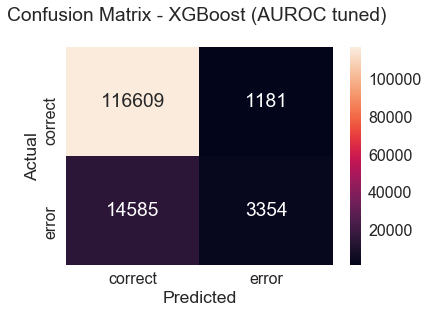

AUC:  0.7969096308924508
F1 score:  0.936678662082704
Accuracy:  0.8838420676495075 

             precision    recall  f1-score   support

          1       0.89      0.99      0.94    117790
          0       0.74      0.19      0.30     17939

avg / total       0.87      0.88      0.85    135729



In [105]:
# plot confusion matrix
cmtrx = confusion_matrix(ytest, xgb_auc_pred, labels=[1,0])
ed.plot_confusion_matrix(cmtrx, 'XGBoost (AUROC tuned)')
print("AUC: ", roc_auc_score(ytest, xgb_pred_proba))
print("F1 score: ", f1_score(ytest, xgb_auc_pred))
print("Accuracy: ", accuracy_score(ytest, xgb_auc_pred), '\n')
print(classification_report(ytest, xgb_auc_pred, labels=[1,0]))

### Analysis of model

The initial model has produced an encouraging result, but not a huge improvement on the zero rule baseline of simply classifying all words as correct.

The model is capturing just under 20% of the errors (0.19 recall of class 0) at a cost of missclassifying just 1% of correct words as errors (0.99 recall).

Another positive is that the AUROC score is also reasonably high (0.80). This suggests that the model performa consistently well across different class probability thresholds, i.e. there is scope for tweaking the model to reduce the false positives or true negatives without reducing the overall accuracy of the model.




### Tuning XGBoost using F1 Score

The previous model was tuned using the AUROC score. This should give us the XGBoost model that performs the best *across all thresholds*; however, it doesn't necessarily give us the best possible model at a given threshold.

Next, I will try tuning the XGBoost using the F1 score as an evaluation metric instead of AUROC. This might provide us with a less tweakable / flexible model, but one that - *at a specific threshold only* - actually performs better.

In [37]:
def objective(space):

    xgb = XGBClassifier(n_estimators = 100,
                            max_depth = int(space['max_depth']),
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                       )

    eval_set  = [( Xtrain, ytrain), ( Xtest, ytest)]

    xgb.fit(Xtrain, ytrain,
            eval_set=eval_set, eval_metric="auc",
            early_stopping_rounds=30)

    pred = xgb.predict(Xtest)
    f1 = f1_score(ytest, pred)
    print("SCORE:", f1)

    return {'loss':1-f1, 'status': STATUS_OK }


space ={
        'max_depth': hp.quniform("x_max_depth", 5, 30, 1),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
    }

trials_2 = Trials()
best_2 = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,
            trials=trials_2)

[0]	validation_0-auc:0.795262	validation_1-auc:0.744571
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.816889	validation_1-auc:0.75867
[2]	validation_0-auc:0.827186	validation_1-auc:0.763162
[3]	validation_0-auc:0.837214	validation_1-auc:0.767114
[4]	validation_0-auc:0.843727	validation_1-auc:0.768747
[5]	validation_0-auc:0.849921	validation_1-auc:0.770635
[6]	validation_0-auc:0.854661	validation_1-auc:0.772048
[7]	validation_0-auc:0.859136	validation_1-auc:0.773589
[8]	validation_0-auc:0.863151	validation_1-auc:0.774865
[9]	validation_0-auc:0.867937	validation_1-auc:0.776132
[10]	validation_0-auc:0.871966	validation_1-auc:0.776283
[11]	validation_0-auc:0.875713	validation_1-auc:0.777264
[12]	validation_0-auc:0.879267	validation_1-auc:0.77796
[13]	validation_0-auc:0.882426	validation_1-auc:0.778479
[14]	validation_0-auc:0.885403	validation_1-auc:0.778661


[39]	validation_0-auc:0.775948	validation_1-auc:0.762956
[40]	validation_0-auc:0.77655	validation_1-auc:0.763375
[41]	validation_0-auc:0.777786	validation_1-auc:0.76434
[42]	validation_0-auc:0.778188	validation_1-auc:0.764464
[43]	validation_0-auc:0.778847	validation_1-auc:0.764912
[44]	validation_0-auc:0.779664	validation_1-auc:0.765683
[45]	validation_0-auc:0.780262	validation_1-auc:0.766189
[46]	validation_0-auc:0.78127	validation_1-auc:0.766968
[47]	validation_0-auc:0.781983	validation_1-auc:0.767517
[48]	validation_0-auc:0.782637	validation_1-auc:0.768095
[49]	validation_0-auc:0.783288	validation_1-auc:0.768669
[50]	validation_0-auc:0.783645	validation_1-auc:0.768832
[51]	validation_0-auc:0.784295	validation_1-auc:0.769167
[52]	validation_0-auc:0.784863	validation_1-auc:0.769647
[53]	validation_0-auc:0.785403	validation_1-auc:0.769984
[54]	validation_0-auc:0.785746	validation_1-auc:0.770195
[55]	validation_0-auc:0.785954	validation_1-auc:0.77028
[56]	validation_0-auc:0.786152	vali

[81]	validation_0-auc:0.986232	validation_1-auc:0.793125
[82]	validation_0-auc:0.986443	validation_1-auc:0.793602
[83]	validation_0-auc:0.986564	validation_1-auc:0.793689
[84]	validation_0-auc:0.98665	validation_1-auc:0.793925
[85]	validation_0-auc:0.986763	validation_1-auc:0.793803
[86]	validation_0-auc:0.986827	validation_1-auc:0.793967
[87]	validation_0-auc:0.987019	validation_1-auc:0.794031
[88]	validation_0-auc:0.987149	validation_1-auc:0.794063
[89]	validation_0-auc:0.987249	validation_1-auc:0.794081
[90]	validation_0-auc:0.987407	validation_1-auc:0.794144
[91]	validation_0-auc:0.987583	validation_1-auc:0.794162
[92]	validation_0-auc:0.987657	validation_1-auc:0.794213
[93]	validation_0-auc:0.98777	validation_1-auc:0.794209
[94]	validation_0-auc:0.987996	validation_1-auc:0.794839
[95]	validation_0-auc:0.988049	validation_1-auc:0.794895
[96]	validation_0-auc:0.988178	validation_1-auc:0.794855
[97]	validation_0-auc:0.988285	validation_1-auc:0.794848
[98]	validation_0-auc:0.9884	vali

[20]	validation_0-auc:0.905021	validation_1-auc:0.7817
[21]	validation_0-auc:0.907056	validation_1-auc:0.782105
[22]	validation_0-auc:0.909099	validation_1-auc:0.782694
[23]	validation_0-auc:0.910909	validation_1-auc:0.783393
[24]	validation_0-auc:0.912297	validation_1-auc:0.784094
[25]	validation_0-auc:0.913819	validation_1-auc:0.784321
[26]	validation_0-auc:0.915249	validation_1-auc:0.784713
[27]	validation_0-auc:0.916687	validation_1-auc:0.784762
[28]	validation_0-auc:0.917984	validation_1-auc:0.78492
[29]	validation_0-auc:0.919191	validation_1-auc:0.785289
[30]	validation_0-auc:0.920463	validation_1-auc:0.785559
[31]	validation_0-auc:0.921849	validation_1-auc:0.786034
[32]	validation_0-auc:0.922976	validation_1-auc:0.786326
[33]	validation_0-auc:0.924105	validation_1-auc:0.786674
[34]	validation_0-auc:0.92537	validation_1-auc:0.787119
[35]	validation_0-auc:0.926318	validation_1-auc:0.787397
[36]	validation_0-auc:0.927722	validation_1-auc:0.787798
[37]	validation_0-auc:0.928868	vali

[62]	validation_0-auc:0.989797	validation_1-auc:0.791674
[63]	validation_0-auc:0.989937	validation_1-auc:0.791612
[64]	validation_0-auc:0.990098	validation_1-auc:0.791819
[65]	validation_0-auc:0.990238	validation_1-auc:0.791787
[66]	validation_0-auc:0.990347	validation_1-auc:0.792032
[67]	validation_0-auc:0.990505	validation_1-auc:0.79206
[68]	validation_0-auc:0.990632	validation_1-auc:0.7921
[69]	validation_0-auc:0.990722	validation_1-auc:0.792049
[70]	validation_0-auc:0.990912	validation_1-auc:0.792112
[71]	validation_0-auc:0.991021	validation_1-auc:0.792171
[72]	validation_0-auc:0.991175	validation_1-auc:0.792115
[73]	validation_0-auc:0.991329	validation_1-auc:0.792289
[74]	validation_0-auc:0.991425	validation_1-auc:0.792274
[75]	validation_0-auc:0.991603	validation_1-auc:0.792747
[76]	validation_0-auc:0.991717	validation_1-auc:0.792758
[77]	validation_0-auc:0.991839	validation_1-auc:0.792745
[78]	validation_0-auc:0.991885	validation_1-auc:0.79279
[79]	validation_0-auc:0.991922	vali

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.819872	validation_1-auc:0.757153
[2]	validation_0-auc:0.834109	validation_1-auc:0.763263
[3]	validation_0-auc:0.843053	validation_1-auc:0.766442
[4]	validation_0-auc:0.849834	validation_1-auc:0.769472
[5]	validation_0-auc:0.856707	validation_1-auc:0.771673
[6]	validation_0-auc:0.861817	validation_1-auc:0.77351
[7]	validation_0-auc:0.86686	validation_1-auc:0.774771
[8]	validation_0-auc:0.871142	validation_1-auc:0.775963
[9]	validation_0-auc:0.87541	validation_1-auc:0.777315
[10]	validation_0-auc:0.878629	validation_1-auc:0.777603
[11]	validation_0-auc:0.881757	validation_1-auc:0.778329
[12]	validation_0-auc:0.884698	validation_1-auc:0.778983
[13]	validation_0-auc:0.887614	validation_1-auc:0.779464
[14]	validation_0-auc:0.890092	validation_1-auc:0.780001
[15]	validation_0-auc:0.892317	validation_1-auc:0.78056
[16]	validation_0-auc:0.894417	validation_1-auc:0.780733
[17]	validation_0-auc:0.89656	validat

[42]	validation_0-auc:0.979301	validation_1-auc:0.788482
[43]	validation_0-auc:0.97983	validation_1-auc:0.78877
[44]	validation_0-auc:0.980417	validation_1-auc:0.788862
[45]	validation_0-auc:0.981165	validation_1-auc:0.789044
[46]	validation_0-auc:0.98157	validation_1-auc:0.789177
[47]	validation_0-auc:0.982279	validation_1-auc:0.789498
[48]	validation_0-auc:0.982786	validation_1-auc:0.789505
[49]	validation_0-auc:0.983004	validation_1-auc:0.7898
[50]	validation_0-auc:0.983341	validation_1-auc:0.789863
[51]	validation_0-auc:0.983581	validation_1-auc:0.789847
[52]	validation_0-auc:0.983984	validation_1-auc:0.790169
[53]	validation_0-auc:0.98444	validation_1-auc:0.790527
[54]	validation_0-auc:0.984613	validation_1-auc:0.790508
[55]	validation_0-auc:0.984858	validation_1-auc:0.790669
[56]	validation_0-auc:0.985149	validation_1-auc:0.790749
[57]	validation_0-auc:0.985542	validation_1-auc:0.790825
[58]	validation_0-auc:0.985817	validation_1-auc:0.791018
[59]	validation_0-auc:0.986064	valida

[84]	validation_0-auc:0.923336	validation_1-auc:0.797835
[85]	validation_0-auc:0.923923	validation_1-auc:0.797761
[86]	validation_0-auc:0.924596	validation_1-auc:0.797837
[87]	validation_0-auc:0.925229	validation_1-auc:0.797776
[88]	validation_0-auc:0.925689	validation_1-auc:0.797963
[89]	validation_0-auc:0.926054	validation_1-auc:0.797909
[90]	validation_0-auc:0.926875	validation_1-auc:0.797861
[91]	validation_0-auc:0.927187	validation_1-auc:0.797997
[92]	validation_0-auc:0.92759	validation_1-auc:0.798246
[93]	validation_0-auc:0.927951	validation_1-auc:0.798304
[94]	validation_0-auc:0.928378	validation_1-auc:0.798336
[95]	validation_0-auc:0.928778	validation_1-auc:0.798504
[96]	validation_0-auc:0.92888	validation_1-auc:0.798537
[97]	validation_0-auc:0.92905	validation_1-auc:0.798554
[98]	validation_0-auc:0.929851	validation_1-auc:0.798993
[99]	validation_0-auc:0.930203	validation_1-auc:0.799038
SCORE: 0.9368940991572515
[0]	validation_0-auc:0.800087	validation_1-auc:0.74226
Multiple e

[23]	validation_0-auc:0.930075	validation_1-auc:0.783549
[24]	validation_0-auc:0.931849	validation_1-auc:0.784331
[25]	validation_0-auc:0.933692	validation_1-auc:0.784452
[26]	validation_0-auc:0.935371	validation_1-auc:0.784536
[27]	validation_0-auc:0.936811	validation_1-auc:0.784634
[28]	validation_0-auc:0.938227	validation_1-auc:0.784743
[29]	validation_0-auc:0.939953	validation_1-auc:0.785226
[30]	validation_0-auc:0.941318	validation_1-auc:0.785438
[31]	validation_0-auc:0.942752	validation_1-auc:0.785687
[32]	validation_0-auc:0.943956	validation_1-auc:0.785929
[33]	validation_0-auc:0.945083	validation_1-auc:0.786338
[34]	validation_0-auc:0.94655	validation_1-auc:0.78649
[35]	validation_0-auc:0.947615	validation_1-auc:0.786783
[36]	validation_0-auc:0.94884	validation_1-auc:0.787053
[37]	validation_0-auc:0.949894	validation_1-auc:0.787232
[38]	validation_0-auc:0.951132	validation_1-auc:0.787431
[39]	validation_0-auc:0.952198	validation_1-auc:0.787661
[40]	validation_0-auc:0.953003	val

[65]	validation_0-auc:0.954552	validation_1-auc:0.791527
[66]	validation_0-auc:0.955101	validation_1-auc:0.791508
[67]	validation_0-auc:0.955232	validation_1-auc:0.79161
[68]	validation_0-auc:0.955744	validation_1-auc:0.791735
[69]	validation_0-auc:0.95586	validation_1-auc:0.791762
[70]	validation_0-auc:0.956691	validation_1-auc:0.791957
[71]	validation_0-auc:0.956898	validation_1-auc:0.792098
[72]	validation_0-auc:0.957478	validation_1-auc:0.792577
[73]	validation_0-auc:0.957726	validation_1-auc:0.792565
[74]	validation_0-auc:0.957887	validation_1-auc:0.792611
[75]	validation_0-auc:0.958234	validation_1-auc:0.792659
[76]	validation_0-auc:0.958336	validation_1-auc:0.79275
[77]	validation_0-auc:0.958919	validation_1-auc:0.793442
[78]	validation_0-auc:0.95902	validation_1-auc:0.793415
[79]	validation_0-auc:0.959264	validation_1-auc:0.793529
[80]	validation_0-auc:0.959519	validation_1-auc:0.793599
[81]	validation_0-auc:0.959899	validation_1-auc:0.794221
[82]	validation_0-auc:0.960099	vali

[4]	validation_0-auc:0.807106	validation_1-auc:0.762839
[5]	validation_0-auc:0.811584	validation_1-auc:0.76484
[6]	validation_0-auc:0.815003	validation_1-auc:0.766103
[7]	validation_0-auc:0.818054	validation_1-auc:0.767289
[8]	validation_0-auc:0.82209	validation_1-auc:0.769168
[9]	validation_0-auc:0.825176	validation_1-auc:0.770598
[10]	validation_0-auc:0.828959	validation_1-auc:0.771087
[11]	validation_0-auc:0.832202	validation_1-auc:0.771958
[12]	validation_0-auc:0.835383	validation_1-auc:0.772655
[13]	validation_0-auc:0.838558	validation_1-auc:0.773531
[14]	validation_0-auc:0.841199	validation_1-auc:0.774459
[15]	validation_0-auc:0.843835	validation_1-auc:0.775229
[16]	validation_0-auc:0.845187	validation_1-auc:0.775738
[17]	validation_0-auc:0.847757	validation_1-auc:0.776528
[18]	validation_0-auc:0.850497	validation_1-auc:0.777052
[19]	validation_0-auc:0.85273	validation_1-auc:0.777767
[20]	validation_0-auc:0.855218	validation_1-auc:0.77847
[21]	validation_0-auc:0.85779	validation_

[46]	validation_0-auc:0.949903	validation_1-auc:0.789073
[47]	validation_0-auc:0.950631	validation_1-auc:0.78911
[48]	validation_0-auc:0.951301	validation_1-auc:0.78924
[49]	validation_0-auc:0.95202	validation_1-auc:0.789083
[50]	validation_0-auc:0.952375	validation_1-auc:0.789159
[51]	validation_0-auc:0.953024	validation_1-auc:0.789149
[52]	validation_0-auc:0.953601	validation_1-auc:0.78943
[53]	validation_0-auc:0.954188	validation_1-auc:0.789547
[54]	validation_0-auc:0.954701	validation_1-auc:0.789999
[55]	validation_0-auc:0.955099	validation_1-auc:0.790014
[56]	validation_0-auc:0.955351	validation_1-auc:0.790109
[57]	validation_0-auc:0.956019	validation_1-auc:0.79017
[58]	validation_0-auc:0.956436	validation_1-auc:0.790563
[59]	validation_0-auc:0.957055	validation_1-auc:0.791034
[60]	validation_0-auc:0.957403	validation_1-auc:0.791132
[61]	validation_0-auc:0.957879	validation_1-auc:0.791152
[62]	validation_0-auc:0.958317	validation_1-auc:0.791223
[63]	validation_0-auc:0.959004	valid

[88]	validation_0-auc:0.970311	validation_1-auc:0.79447
[89]	validation_0-auc:0.970471	validation_1-auc:0.794561
[90]	validation_0-auc:0.970796	validation_1-auc:0.794504
[91]	validation_0-auc:0.970988	validation_1-auc:0.794502
[92]	validation_0-auc:0.971088	validation_1-auc:0.794607
[93]	validation_0-auc:0.971178	validation_1-auc:0.794644
[94]	validation_0-auc:0.971636	validation_1-auc:0.795151
[95]	validation_0-auc:0.971835	validation_1-auc:0.795243
[96]	validation_0-auc:0.972077	validation_1-auc:0.795227
[97]	validation_0-auc:0.97213	validation_1-auc:0.795226
[98]	validation_0-auc:0.972449	validation_1-auc:0.795473
[99]	validation_0-auc:0.972586	validation_1-auc:0.795476
SCORE: 0.9368095768150421
[0]	validation_0-auc:0.803952	validation_1-auc:0.743206
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.828792	validation_1-auc:0.756053
[2]	validation_0-auc:0.

[27]	validation_0-auc:0.944174	validation_1-auc:0.785361
[28]	validation_0-auc:0.945529	validation_1-auc:0.785492
[29]	validation_0-auc:0.946825	validation_1-auc:0.785629
[30]	validation_0-auc:0.948405	validation_1-auc:0.785783
[31]	validation_0-auc:0.949884	validation_1-auc:0.785965
[32]	validation_0-auc:0.951385	validation_1-auc:0.78619
[33]	validation_0-auc:0.952513	validation_1-auc:0.786342
[34]	validation_0-auc:0.953557	validation_1-auc:0.786385
[35]	validation_0-auc:0.954694	validation_1-auc:0.786722
[36]	validation_0-auc:0.955719	validation_1-auc:0.786865
[37]	validation_0-auc:0.956891	validation_1-auc:0.786985
[38]	validation_0-auc:0.957895	validation_1-auc:0.787104
[39]	validation_0-auc:0.958724	validation_1-auc:0.787329
[40]	validation_0-auc:0.959569	validation_1-auc:0.787306
[41]	validation_0-auc:0.960377	validation_1-auc:0.787484
[42]	validation_0-auc:0.961247	validation_1-auc:0.787683
[43]	validation_0-auc:0.96204	validation_1-auc:0.787933
[44]	validation_0-auc:0.962835	va

[69]	validation_0-auc:0.996808	validation_1-auc:0.791638
[70]	validation_0-auc:0.996861	validation_1-auc:0.791825
[71]	validation_0-auc:0.996907	validation_1-auc:0.792291
[72]	validation_0-auc:0.996954	validation_1-auc:0.792322
[73]	validation_0-auc:0.996971	validation_1-auc:0.792424
[74]	validation_0-auc:0.996987	validation_1-auc:0.792564
[75]	validation_0-auc:0.997016	validation_1-auc:0.792593
[76]	validation_0-auc:0.997034	validation_1-auc:0.792644
[77]	validation_0-auc:0.997062	validation_1-auc:0.792682
[78]	validation_0-auc:0.997085	validation_1-auc:0.792692
[79]	validation_0-auc:0.997104	validation_1-auc:0.792662
[80]	validation_0-auc:0.997127	validation_1-auc:0.792677
[81]	validation_0-auc:0.997159	validation_1-auc:0.79264
[82]	validation_0-auc:0.997192	validation_1-auc:0.79262
[83]	validation_0-auc:0.997216	validation_1-auc:0.792641
[84]	validation_0-auc:0.997241	validation_1-auc:0.792634
[85]	validation_0-auc:0.997256	validation_1-auc:0.792795
[86]	validation_0-auc:0.997295	va

In [38]:
# save best parameters
best_params_xgb_f1 = space_eval(space, best_2)

In [41]:
# print best parameters
print(best_params_xgb_f1)

{'max_depth': 16.0, 'min_child_weight': 6.0, 'subsample': 0.8176182078838173}


### Evaluation of XGBoost model tuned for F1 score

In [ ]:
# Fit the model using best parameters and predict values
xgb = XGBClassifier(
    n_estimators = 100,
    max_depth = int(best_params_xgb_f1["max_depth"]), 
    min_child_weight = best_params_xgb_f1["min_child_weight"],
    subsample = best_params_xgb_f1["subsample"])
xgb.fit(Xtrain, ytrain)
xgb_f1_pred = xgb.predict(Xtest)
xgb_f1_proba = xgb.predict_proba(Xtest)[:,1]

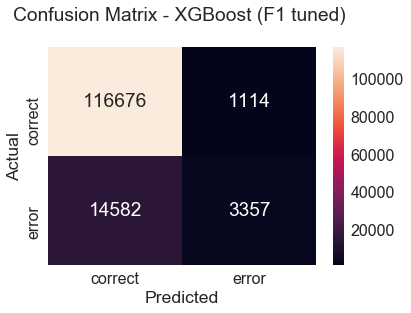

AUC:  0.7957385645246422
F1 score:  0.9369760046256144
Accuracy:  0.8843578012068165 

             precision    recall  f1-score   support

          1       0.89      0.99      0.94    117790
          0       0.75      0.19      0.30     17939

avg / total       0.87      0.88      0.85    135729



In [101]:
# plot confusion matrix
cmtrx = confusion_matrix(ytest, xgb_f1_pred, labels=[1,0])
ed.plot_confusion_matrix(cmtrx, 'XGBoost (F1 tuned)')
print("AUC: ", roc_auc_score(ytest, xgb_f1_proba))
print("F1 score: ", f1_score(ytest, xgb_f1_pred))
print("Accuracy: ", accuracy_score(ytest, xgb_f1_pred), '\n')
print(classification_report(ytest, xgb_f1_pred, labels=[1,0]))

### Analysis of model

By tuning our hyperparameters using the F1 score instead of AUROC, we have very slightly improved the performance of the model in terms of the confusion matrix, F1 score and accuracy. However, this the AUROC score has decreased.

### Tuning a Neural Network using AUROC score

Having identified our best possible XGBoost models, now let's see if I can improve on this using a neural network. 

As before, I will use Bayesian optimisation to tune two models using AUROC and F1 scores and find the best hyperparameters before comparing the score with the XGBoost models.

For a neural network where regularization is applied, standardising the data is crucial.

In [102]:
# Use standard scaler to scale feature matrix
ss = StandardScaler()
Xtrain_s = ss.fit_transform(Xtrain)
Xtest_s = ss.transform(Xtest)
Xeval_s = ss.transform(Xeval)

In [21]:
# Tune model using Hyperopt library
def objective(space):

    nn = MLPClassifier(solver='adam')

    nn.fit(Xtrain_s, ytrain)

    pred = nn.predict_proba(Xtest_s)[:,1]
    auc = roc_auc_score(ytest, pred)
    print("SCORE:", auc)

    return {'loss':1-auc, 'status': STATUS_OK }

space = {
         'max_iter': hp.choice('max_iter', [1500,2000,2500]), 
          'alpha': hp.choice('alpha', np.logspace(-15, -6, 10)), 
          'hidden_layer_sizes': hp.choice('hidden_layer_sizes', [(10, 10, 10, 10, 10), (10, 10, 10, 10, 10, 10)]), 
          'activation': hp.choice('activation', ['relu'])
}

trials_nn = Trials()
best_nn = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,
            trials=trials_nn)

SCORE: 0.7517476704512975
SCORE: 0.7531673881889338
SCORE: 0.7523612528654935
SCORE: 0.7523437122174055
SCORE: 0.7533494684832003
SCORE: 0.7523534896237701
SCORE: 0.7501780346912506
SCORE: 0.751879429283988
SCORE: 0.7519923971342432
SCORE: 0.7512808939479799
SCORE: 0.7523164059942771
SCORE: 0.7509967982969481
SCORE: 0.7525628794539357
SCORE: 0.7520552314043516
SCORE: 0.7530312299966323
SCORE: 0.7528966964817774
SCORE: 0.7519973317429636
SCORE: 0.751931878964171
SCORE: 0.7522743834967868
SCORE: 0.7515987727622907


In [22]:
# Print best parameters found from tuning
best_params_nn = space_eval(space, best_nn)
print(best_params_nn)

{'activation': 'relu', 'alpha': 1e-07, 'hidden_layer_sizes': (10, 10, 10, 10, 10), 'max_iter': 2000}


### Evaluation of neural network 

In [26]:
# Fit the model using best parameters and predict values
nn = MLPClassifier(
    solver = 'adam',
    activation = best_params_nn["activation"], 
    alpha = best_params_nn["alpha"],
    hidden_layer_sizes = best_params_nn["hidden_layer_sizes"],
    max_iter = best_params_nn["max_iter"])
nn.fit(Xtrain_s, ytrain)
nn_pred = nn.predict(Xtest_s)
nn_proba = nn.predict_proba(Xtest_s)[:,1]

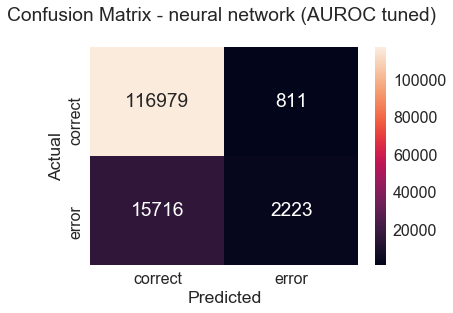

             precision    recall  f1-score   support

          1       0.88      0.99      0.93    117790
          0       0.73      0.12      0.21     17939

avg / total       0.86      0.88      0.84    135729

AUC:  0.7444096200194639
F1 score:  0.9340200011976766
Accuracy:  0.8782353071193334


In [106]:
# Display the confusion matrix
cmtrx = confusion_matrix(ytest, nn_pred, labels=[1,0])
ed.plot_confusion_matrix(cmtrx, "neural network (AUROC tuned)")

# Print the classification report
print(classification_report(ytest, nn_pred, labels=[1,0]))
print("AUC: ", roc_auc_score(ytest, nn_proba))
print("F1 score: ", f1_score(ytest, nn_pred))
print("Accuracy: ", accuracy_score(ytest, nn_pred))

### Analysis of model

The MLP classifier performs worse than both XGBoost models on all metrics. 

While the the recall of the correct class / false negative rate has decreased very slightly (811 false negatives compared to 1114), this is at the expense of a significantly lower recall on the error class (0.12 compared to 0.19). In other words, if we simply adjusted the threshold on either of the XGBoost models, we would be able to achieve the same false negative rate while still achieving a higher recall on the error class.

The most significant decrease in performance is on the AUROC smetric, which has decreased by nearly 6 percentage points, which suggests that this model performs worse than across a range of decision thresholds.

Would this improve if we tuned on the F1 score instead?

### Tuning a neural network using F1 Score

In [69]:
def objective(space):

    nn = MLPClassifier(solver='adam')

    nn.fit(Xtrain_s, ytrain)

    pred = nn.predict_proba(Xtest)[:,1]
    pred_ = nn.predict(Xtest)
    auc = roc_auc_score(ytest, pred)
    f1 = f1_score(ytest, pred_)
    print("f1_score: ", f1)
    
    return {'loss':1-auc, 'status': STATUS_OK }

space = {
         'max_iter': hp.choice('max_iter', [1500,2000,2500]), 
          'alpha': hp.choice('alpha', np.logspace(-15, -6, 10)), 
          'hidden_layer_sizes': hp.choice('hidden_layer_sizes', [(10, 10, 10, 10, 10), (10, 10, 10, 10, 10, 10)]), 
          'activation': hp.choice('activation', ['relu'])
}

trials_nn = Trials()
best_nn = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,
            trials=trials_nn)

f1_score:  0.9292400175134803
f1_score:  0.9292400175134803
f1_score:  0.9292400175134803
f1_score:  0.6608687602217673
f1_score:  0.9292400175134803
f1_score:  0.8875844612262829
f1_score:  0.9128069354083592
f1_score:  0.9292400175134803
f1_score:  0.9292400175134803
f1_score:  0.9292400175134803
f1_score:  0.8827128006702847
f1_score:  0.6118487708633286
f1_score:  0.9292400175134803
f1_score:  0.9075121523692048
f1_score:  0.9211735567145245
f1_score:  0.9292400175134803
f1_score:  0.9292400175134803
f1_score:  0.7681200293304754
f1_score:  0.9292357939081249
f1_score:  0.9214267797919313


In [70]:
# print best parameters
best_params_nn_f1 = space_eval(space, best_nn)
print(best_params_nn_f1)

{'activation': 'relu', 'alpha': 1e-11, 'hidden_layer_sizes': (10, 10, 10, 10, 10, 10), 'max_iter': 2000}


### Evaluation of neural network tuned for F1 score

In [71]:
# Fit the model using best parameters and predict values
nn = MLPClassifier(
    solver = 'adam',
    activation = best_params_nn_f1["activation"], 
    alpha = best_params_nn_f1["alpha"],
    hidden_layer_sizes = best_params_nn_f1["hidden_layer_sizes"],
    max_iter = best_params_nn_f1["max_iter"])
nn.fit(Xtrain_s, ytrain)
nn_f1_pred = nn.predict(Xtest_s)
nn_f1_proba = nn.predict_proba(Xtest_s)[:,1]

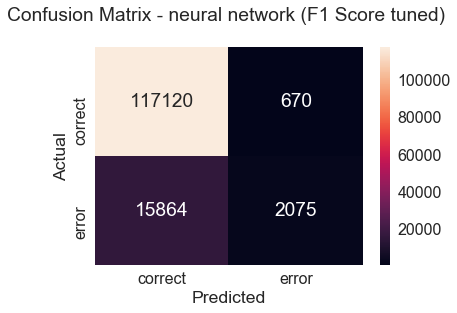

In [124]:
cmtrx = confusion_matrix(ytest, nn_f1_pred, labels=[1,0])
ed.plot_confusion_matrix(cmtrx, "neural network (F1 Score tuned)")

In [74]:
print(classification_report(ytest, nn_f1_pred, labels=[1,0]))
print("AUC: ", roc_auc_score(ytest, nn_f1_proba))
print("F1 score: ", f1_score(ytest, nn_f1_pred))
print("Accuracy: ", accuracy_score(ytest, nn_f1_pred))

             precision    recall  f1-score   support

          1       0.88      0.99      0.93    117790
          0       0.76      0.12      0.20     17939

avg / total       0.86      0.88      0.84    135729

AUC:  0.7477658557835116
F1 score:  0.9340681250847377
Accuracy:  0.8781837337636025


### Analysis of model

Tuning the model using the F1 score has produced an almost identical result as using the AUROC metric. The F1 score has improved by a miniscule amount, but all other metrics have remained the same.


### Tuning Random Forest using AUROC

I will now tune a Random Forest classifier to see if a better score can be achieved that both neural network and XGBoost algorithms.

In [290]:
def objective(space):

    rf = RandomForestClassifier(n_estimators = space['n_estimators'],
                            max_depth = int(space['max_depth']),
                            max_features = space['max_features'],
                            criterion = space['criterion'],
                       )

    rf.fit(Xtrain, ytrain)

    pred = rf.predict_proba(Xtest)[:,1]
    auc = roc_auc_score(ytest, pred)
    print("SCORE:", auc)

    return {'loss':1-auc, 'status': STATUS_OK }


space ={
        'max_depth': hp.choice('max_depth', range(1,20)),
        'max_features': hp.choice('max_features', range(1,len(Xtrain.columns))),
        'n_estimators': hp.choice('n_estimators', range(75,125)),
        'criterion': hp.choice('criterion', ["gini", "entropy"]),
    }

trials_rf = Trials()
best_rf = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,
            trials=trials)


SCORE: 0.7743482787205005
SCORE: 0.7771110566796579
SCORE: 0.7582956801833283
SCORE: 0.7849611079052692
SCORE: 0.7489883652224357
SCORE: 0.6125950927897871
SCORE: 0.766629075315612
SCORE: 0.7686060091456799
SCORE: 0.7230624255546457
SCORE: 0.7807040336926585
SCORE: 0.7167557159174297
SCORE: 0.7351339711246877
SCORE: 0.7853215456493119
SCORE: 0.6962381379320486
SCORE: 0.7089491060017132
SCORE: 0.7132387766957801
SCORE: 0.70342102007302
SCORE: 0.7567908788970684
SCORE: 0.6963503585158637


In [ ]:
# print best parameters
best_params_rf = space_eval(space, best_rf)
print(best_params_rf)

### Evaluation of Random Forest model

In [324]:
# Fit the model using best parameters and predict values on holdout set
rf = RandomForestClassifier(
    n_estimators = best_params_rf["n_estimators"],
    max_depth = best_params_rf["max_depth"], 
    max_features = best_params_rf["max_features"],
    criterion = best_params_rf["criterion"])
rf.fit(Xtrain, ytrain)


In [131]:
# Find predictions and predicted probabilities
rf_pred_proba = rf.predict_proba(Xtest)[:,1]
rf_pred = rf.predict(Xtest)

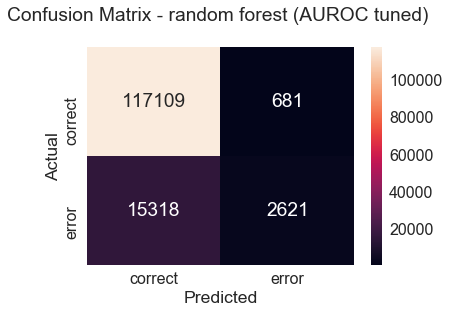

In [132]:
cmtrx = confusion_matrix(ytest, rf_pred, labels=[1,0])
ed.plot_confusion_matrix(cmtrx, "random forest (AUROC tuned)")

In [136]:
print(classification_report(ytest, rf_pred, labels=[1,0]))
print("AUC: ", roc_auc_score(ytest, rf_pred_proba))
print("F1 score: ", f1_score(ytest, rf_pred))
print("Accuracy: ", accuracy_score(ytest, rf_pred))

             precision    recall  f1-score   support

          1       0.88      0.99      0.94    117790
          0       0.79      0.15      0.25     17939

avg / total       0.87      0.88      0.84    135729

AUC:  0.7846360964588179
F1 score:  0.936059500353693
Accuracy:  0.8821254116658931


### Analysis of model

While Random Forest is an improvement on the MLP classifier, it is still marginally worse than XGBoost on all metric.

Finally, I will try tuning the Random Forest using the F1 score.


### Tuning Random Forest using F1 Score


In [79]:
def objective(space):

    rf = RandomForestClassifier(n_estimators = space['n_estimators'],
                            max_depth = int(space['max_depth']),
                            max_features = space['max_features'],
                            criterion = space['criterion'],
                       )

    rf.fit(Xtrain, ytrain)

    pred = rf.predict_proba(Xtest)[:,1]
    pred_ = rf.predict(Xtest)
    auc = roc_auc_score(ytest, pred)
    f1 = f1_score(ytest, pred_)
    print("f1_score: ", f1)
    print("SCORE:", auc)

    return {'loss':1-f1, 'status': STATUS_OK }


space ={
        'max_depth': hp.choice('max_depth', range(1,20)),
        'max_features': hp.choice('max_features', range(1,len(Xtrain.columns))),
        'n_estimators': hp.choice('n_estimators', range(75,125)),
        'criterion': hp.choice('criterion', ["gini", "entropy"]),
    }

trials_rf_f1 = Trials()
best_rf_f1 = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,
            trials=trials_rf_f1)


f1_score:  0.9360764202795357
SCORE: 0.7840967494520358
f1_score:  0.9359208730152395
SCORE: 0.7741941485100285
f1_score:  0.9339188524460101
SCORE: 0.7122249793887683
f1_score:  0.9359124268194862
SCORE: 0.779215024621388
f1_score:  0.9360694301883928
SCORE: 0.7785030779970917
f1_score:  0.9345629517198631
SCORE: 0.7417845380881349
f1_score:  0.9361678321678321
SCORE: 0.781069144336529
f1_score:  0.9354453268757418
SCORE: 0.7650328874610448
f1_score:  0.9343415068536718
SCORE: 0.744172706033177
f1_score:  0.935716593087111
SCORE: 0.7751979684612957
f1_score:  0.9361685122503868
SCORE: 0.7847241283734461
f1_score:  0.9357970760327153
SCORE: 0.772410546090341
f1_score:  0.9292400175134803
SCORE: 0.6951617777655068
f1_score:  0.934537694572824
SCORE: 0.7360786119751619
f1_score:  0.9340972161480904
SCORE: 0.7386085982180294
f1_score:  0.9360678789428271
SCORE: 0.7856116490101741
f1_score:  0.9354143512155869
SCORE: 0.7623202504174553
f1_score:  0.9359424639601527
SCORE: 0.778810220121267

In [141]:
best_params_rf_f1 = space_eval(space, best_rf_f1)
print(best_params_rf_f1)

{'criterion': 'entropy', 'max_depth': 15, 'max_features': 14, 'n_estimators': 81}


### Evaluation of XGBoost model tuned for F1 score

In [142]:
# Fit the model using best parameters and predict values on holdout set
rf = RandomForestClassifier(
    n_estimators = best_params_rf_f1["n_estimators"],
    max_depth = best_params_rf_f1["max_depth"], 
    max_features = best_params_rf_f1["max_features"],
    criterion = best_params_rf_f1["criterion"])
rf.fit(Xtrain, ytrain)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=15, max_features=14, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=81, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [143]:
# get predictions and predicted probabilities
rf_f1_proba = rf.predict_proba(Xtest)[:,1]
rf_f1_pred = rf.predict(Xtest)

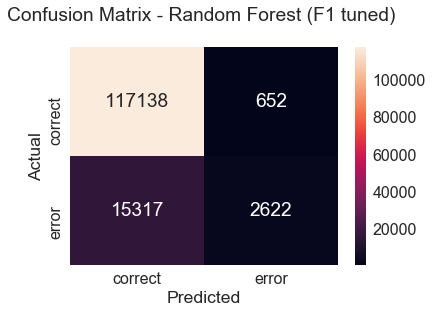

In [144]:
cmtrx = confusion_matrix(ytest, rf_f1_pred, labels=[1,0])
ed.plot_confusion_matrix(cmtrx, "Random Forest (F1 tuned)")

In [145]:
print(classification_report(ytest, rf_f1_pred, labels=[1,0]))
print("AUC: ", roc_auc_score(ytest, rf_f1_proba))
print("F1 score: ", f1_score(ytest, rf_f1_pred))
print("Accuracy: ", accuracy_score(ytest, rf_f1_pred))

             precision    recall  f1-score   support

          1       0.88      0.99      0.94    117790
          0       0.80      0.15      0.25     17939

avg / total       0.87      0.88      0.85    135729

AUC:  0.7859419757973604
F1 score:  0.9361865371935503
Accuracy:  0.8823464403333112


### Analysis of model

The final Random Forest model performs almost identically to the previous one. Again, no improvement on the still leading XGBoost models.

## Final model selection and evaluation

XGBoost is the clear winner out of the three algorithms used - this was the case whether tuning for AUROC and F1 Score. 

The best performing model at a given threshold was the F! scored model. I will now train that on the entire training set before evaluating of the holdout set.


In [147]:
# forward fill the original training predictor matrix to remove null values
X.loc[:, "unigram_mean":"fivegram_mean"] = X.loc[
    :, "unigram_mean":"fivegram_mean"].fillna(method='ffill', axis=1)
X.loc[:, "proba_word":"proba_fivegram_5"] = X.loc[
    :, "proba_word":"proba_fivegram_5"].fillna(method='ffill', axis=1)

In [148]:
# Fit the final model using best XGboost parameters and predict values on holdout set
xgb = XGBClassifier(
    n_estimators = 100,
    max_depth = int(best_params_xgb_f1["max_depth"]), 
    min_child_weight = best_params_xgb_f1["min_child_weight"],
    subsample = best_params_xgb_f1["subsample"])
xgb.fit(X, y)
xgb_pred_eval = xgb.predict(Xeval)
xgb_proba_eval = xgb.predict_proba(Xeval)[:,1]

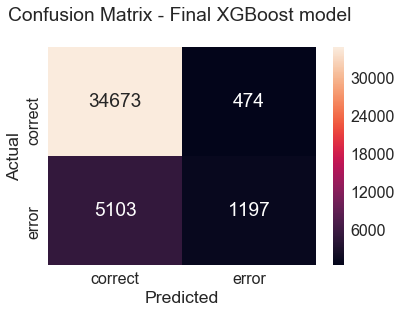

In [149]:
cmtrx = confusion_matrix(yeval, xgb_pred_eval, labels=[1,0])
ed.plot_confusion_matrix(cmtrx, "Final XGBoost model")

In [150]:
print(classification_report(yeval, xgb_pred_eval, labels=[1,0]))
print("AUC: ", roc_auc_score(yeval, xgb_proba_eval))
print("F1 score: ", f1_score(yeval, xgb_pred_eval))
print("Accuracy: ", accuracy_score(yeval, xgb_pred_eval))

             precision    recall  f1-score   support

          1       0.87      0.99      0.93     35147
          0       0.72      0.19      0.30      6300

avg / total       0.85      0.87      0.83     41447

AUC:  0.7855150792973367
F1 score:  0.9255635786073703
Accuracy:  0.8654426134581513


### Analysis of final generalisation errors

The final model performs almost identically on the holdout set to how it performed on the test test. This suggests that we have avoided overfitting at the tuning stage.

To summarise the final results: the XGBoost model is able to pick up around 1 in 5 of the errors in the exam papers while only missclassifying 1% of the correct words. This fits our original preference of avoiding false negatives, although the low error detection rate is rather disappointing. It is also worth mentioning that the model performs well over a range of thresholds, meaning that it could easily be tweaked depending on learner needs.




### Which features are most important?

It is also interesting to look at which of the selected features have the greatest importance in the model.


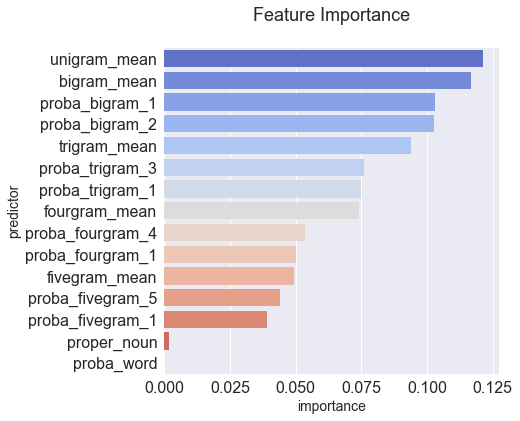

In [229]:
# plot feature importances
xgb_features = pd.DataFrame()
xgb_features["importance"] = xgb.feature_importances_.ravel()
xgb_features["predictor"] = Xeval.columns
xgb_features.sort_values(by="importance", ascending=False, inplace=True)
fig, ax = plt.subplots(figsize = (6,6))
plt.title('Feature Importance\n', fontsize=18)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
sns.barplot(y=xgb_features.predictor, x=xgb_features.importance, orient='h', palette='coolwarm', ax=ax)
sns.color_palette()
plt.show()

The plot clearly shows that lower order n-grams are more important that higher order ones in the XGBoost model. Also, the mean count values have greater importance than the n-gram probabilities.

## A more detailed look at the final model

Having selected the best model an evaluated the feature importances, it would now be useful to look in more detail about how the model is performing. In particular, it would be interesting to answer the following:

- Can we identify any types of errors that the model is particularly good / bad at picking up?
- Do the probabilities provide any further information that can be used to improve the model?
- What would be the next steps to improve the model based on the above information?

Let's start by creating a dataframe including the model predictions, probabilities and the true values for comparison purposes.

In [222]:
# Create dataframe
comparison = pd.DataFrame()
comparison["word"] = df_test["word"]
comparison["xgb_pred"] = xgb_pred_eval
comparison["proba_xgb"] = xgb_proba_eval
comparison["true"] = yeval

### Analysing the true negatives 

Let's take the first 20 correctly predicted errors to see if there are any interesting trends here.

In [223]:
mask = (comparison["true"] == 0) & (comparison["xgb_pred"] == 0)
comparison[mask].head(25)

,word,xgb_pred,proba_xgb,true
110,jean,0,0.164250,0
179,",",0,0.454416,0
201,Your,0,0.021599,0
220,effects,0,0.363225,0
347,internet,0,0.370623,0
365,internet,0,0.217628,0
378,this,0,0.424703,0
414,effect,0,0.240758,0
455,willness,0,0.067908,0
501,finish,0,0.403513,0


While many of these are spelling errors, there also appear to be a number of correctly spelled words. Let's take a few of these and look at the surrounding context.


In [169]:
comparison.loc[216:224]

,word,xgb_pred,proba_xgb,true
216,?,1,0.970836,1
217,I,1,0.959012,1
218,think,1,0.926632,1
219,it,1,0.872488,1
220,effects,0,0.363225,0
221,more,1,0.761725,0
222,than,1,0.937533,1
223,you,1,0.945540,1
224,think,1,0.932131,1


In [173]:
comparison.loc[374:382]

,word,xgb_pred,proba_xgb,true
374,before,1,0.644081,1
375,.,1,0.975151,1
376,In,1,0.932930,1
377,addition,1,0.905322,1
378,this,0,0.424703,0
379,",",0,0.499265,1
380,today,1,0.567946,1
381,companies,1,0.725994,1
382,can,1,0.963837,1


In [186]:
comparison.loc[175:184]

,word,xgb_pred,proba_xgb,true
175,find,1,0.939041,1
176,all,1,0.956136,1
177,the,1,0.954863,1
178,details,1,0.973330,1
179,",",0,0.454416,0
180,which,1,0.949957,1
181,you,1,0.946261,1
182,would,1,0.960224,1
183,like,1,0.982389,1
184,to,1,0.985475,1


Interestingly, the model is also able to detect some punctuation errors, missing words and a situation where a noun is used instead of a verb.

### Analysing false positives
In a similar vein, let's next look at where my model is predicting a word as correct and the word is labelled as an error.

In [196]:
mask = (comparison["true"] == 0) & (comparison["xgb_pred"] == 1)
comparison[mask].head(25)

,word,xgb_pred,proba_xgb,true
12,that,1,0.785287,0
13,you,1,0.943763,0
14,would,1,0.947382,0
15,like,1,0.992548,0
16,me,1,0.965835,0
17,to,1,0.986811,0
18,inform,1,0.948161,0
19,you,1,0.976089,0
27,whose,1,0.930987,0
28,name,1,0.914509,0


Again, there doesn't appear to be a particular trend in the types of errors being misclassified. The first few examples are who phrases that are marked as incorrect, but the rest are individual words.

Let's look at the surrounding context of a few examples (choosing both margin probabilities and those closer to 1) to see if this shows anything interesting.

In [198]:
comparison.loc[106:112]

,word,xgb_pred,proba_xgb,true
106,suitable,1,0.958221,1
107,to,1,0.884758,1
108,wear,1,0.799073,1
109,a,1,0.538286,0
110,jean,0,0.164250,0
111,or,1,0.698426,1
112,something,1,0.736699,1


In [208]:
comparison.loc[80:91]

,word,xgb_pred,proba_xgb,true
80,party,1,0.880296,1
81,will,1,0.878929,1
82,be,1,0.925466,1
83,formal,0,0.267705,1
84,",",1,0.917166,1
85,therefore,1,0.673949,1
86,you,1,0.857812,1
87,have,1,0.936419,0
88,to,1,0.937856,1
89,wear,1,0.951346,1


In [209]:
comparison.loc[185:198]

,word,xgb_pred,proba_xgb,true
185,have,1,0.903793,1
186,in,1,0.570343,1
187,the,1,0.873290,1
188,letter,1,0.888605,1
189,.,1,0.985596,1
190,If,1,0.980360,1
191,you,1,0.982150,1
192,need,1,0.922884,1
193,any,1,0.941634,1
194,information,1,0.937558,0


### Are these false positives really false positives?

This is much more interesting. Looking at the surrounding context in the the first example, the model is spotting the error, but only classifying the word "jean" as an error as opposed to both "jean" and "a".

In the second and third examples, the "true" label of 0 is probably debateable. 

Taking the second example, the label is perhaps justified by the context of the preceding phrase being in the future tense ("party will be formal"), meaning there is a missing "will". Although this is a debateable grammar rule.

Taking the third example, again the given label is debateable. "Any information" seems perfectly natural in this context and it is hard to understand why this has been marked as an error.

This analysis suggests that my model is perhaps performing much better on the positive class recall measure than suggested by the evaluation metrics.

### Analysing the false negatives

In [224]:
mask = (comparison["true"] == 1) & (comparison["xgb_pred"] == 0)
comparison[mask].head(25)

,word,xgb_pred,proba_xgb,true
83,formal,0,0.267705,1
206,Computurs,0,0.067908,1
268,in,0,0.493282,1
379,",",0,0.499265,1
491,signs,0,0.464543,1
600,38755980,0,0.067908,1
707,facilities,0,0.427385,1
808,help,0,0.440467,1
812,need,0,0.472861,1
928,Glouster,0,0.054313,1


One interesting trend here is that a few numbers are being predicted by my model as errors. This could be due to sparsity issues.

There are also a couple of debateable true labels: "Glouster" and "Computurs" both seem like spelling errors that should be labelled as incorrect.

Again, let's look at the surrounding context of some of these examples to see if this provides any additional useful information.


In [215]:
comparison.loc[484:495]

,word,xgb_pred,proba_xgb,true
484,all,1,0.899747,1
485,the,1,0.857367,1
486,main,1,0.934232,1
487,routes,1,0.968155,1
488,in,1,0.723437,1
489,Devonport,1,0.726490,1
490,have,1,0.578171,1
491,signs,0,0.464543,1
492,with,1,0.666171,0
493,correct,1,0.564320,1


In [227]:
comparison.loc[1030:1043]

,word,xgb_pred,proba_xgb,true
1030,the,1,0.936462,1
1031,last,1,0.803663,1
1032,day,1,0.754128,1
1033,you,1,0.842491,0
1034,and,1,0.947901,1
1035,your,1,0.954044,1
1036,group,1,0.931822,1
1037,may,1,0.939816,0
1038,be,0,0.461451,0
1039,go,0,0.106984,1


In [219]:
comparison[1220:1232]

,word,xgb_pred,proba_xgb,true
1221,all,1,0.842717,0
1222,my,1,0.754831,1
1223,College,1,0.512006,0
1224,an,0,0.203688,0
1225,my,0,0.285828,0
1226,were,0,0.474784,1
1227,lofing,0,0.030945,0
1228,was,1,0.742377,1
1229,very,1,0.915333,1
1230,dificul,0,0.067908,0


### More reasons for optimism?

As before, looking at the surrounding contexts gives us more reason for optimism about the predictive power of the 

In the first and second examples, the model is picking up the error but assigning it the previous or subsequent word.

In the third example, the language is so full of errors, it is hard to pinpoint exactly which words are incorrect given the context. 

## Conclusions

It is clear from the analysis in this notebook that n-gram counts and probabilities do have some significant predictive power in detecting language errors. While the best model I produced was only able to detect around 20% of the errors in the FCE exam scripts, it was nevertheless able to detect a range of different errors (including spelling, missing words, noun/verb confusions and punctuation) from a very small feature set.

Crucially, I believe that there are enough positives in the result to suggest that the approach taken (using ngram counts and probabilities from web-scale corpus) could be combined with an existing language corrector to improve detection.

Moreover, after looking in much more detail at the output of the XGBoost model, it appears that its predictive power is much stronger than suggested by the evaluation metrics:
- Some of the original labels are highly questionable. Often where the model disagreed with the original labels, it could be argued that the model was correct and the original labels wrong.
- Often false negatives produced by the model were just one word away from true negatives. This suggests that the model was identifying the error, but was unable to assign it exactly to a word.

## Next steps and improvements to the model

While the performance of the model would not, I believe there is scope to combine. Moreover, there is also scope to make significant improvements to performance of the model with some small changes. These include:
- **controlling for proper nouns: **replacing proper nouns with wildcard characters in n-gram searches might produce better results by reducing some of the sparsity issues I encountered.
- **using search engine 'hits' in addition to Google Books:** Using search engine and newspaper results in addition to Google Books might also produce better results by reducing sparsity. 
- **building a classifier to detect erroneous *phrases* rather than words: ** Often for non-spelling errors, the model was able to identify the existence of the error, but ended up assigning it to the subsequent or previous word rather than the labelled word. But this is not necessarily a problem. It could be argued that trying to label individual words as errors in an erroneous phrase is a misguided approach to language checking. If we moved to an approach based on phrases, the model would likely perform much better.
- **Exploring unsupervised methods:** Given the difficulties and ambiguities involved in correctly labelling language data, perhaps a clustering approach might perform better than a supervised algorithm.